Carregando shapefile do Brasil e filtrando Rio Grande do Norte...
Estado encontrado: RN
CRS original: EPSG:4674
Grade criada com 51 células de 100x100 km

Grade salva em: grade_analise_RN.shp
Total de células criadas: 51
Processando ano 1990...
Processando ano 2000...
Processando ano 2010...
Processando ano 2020...

Processando dados de radiação solar...

Distribuição das células por categoria de mudança:
categoria
Moderada         25
Baixa mudança    13
Alta mudança     13
Name: count, dtype: int64

Mudança total - Q25: -8.78%, Q75: -1.43%

Analisando variável: SIS

Comparação entre categorias para SIS:

Baixa mudança:
  Taxa anual média: 0.3142
  Mudança total média: 16.2051

Moderada:
  Taxa anual média: 0.2588
  Mudança total média: 11.3719

Alta mudança:
  Taxa anual média: 0.2498
  Mudança total média: 10.4575


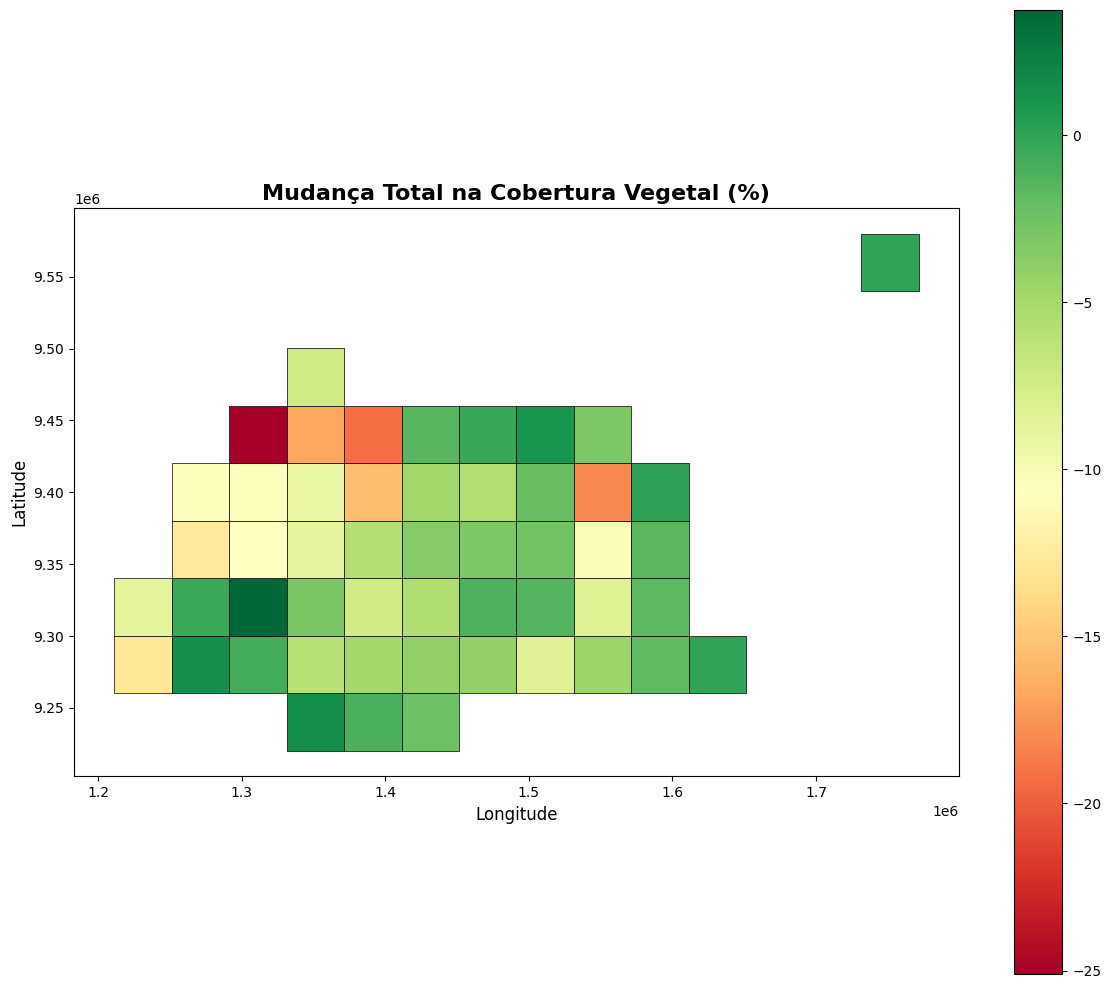

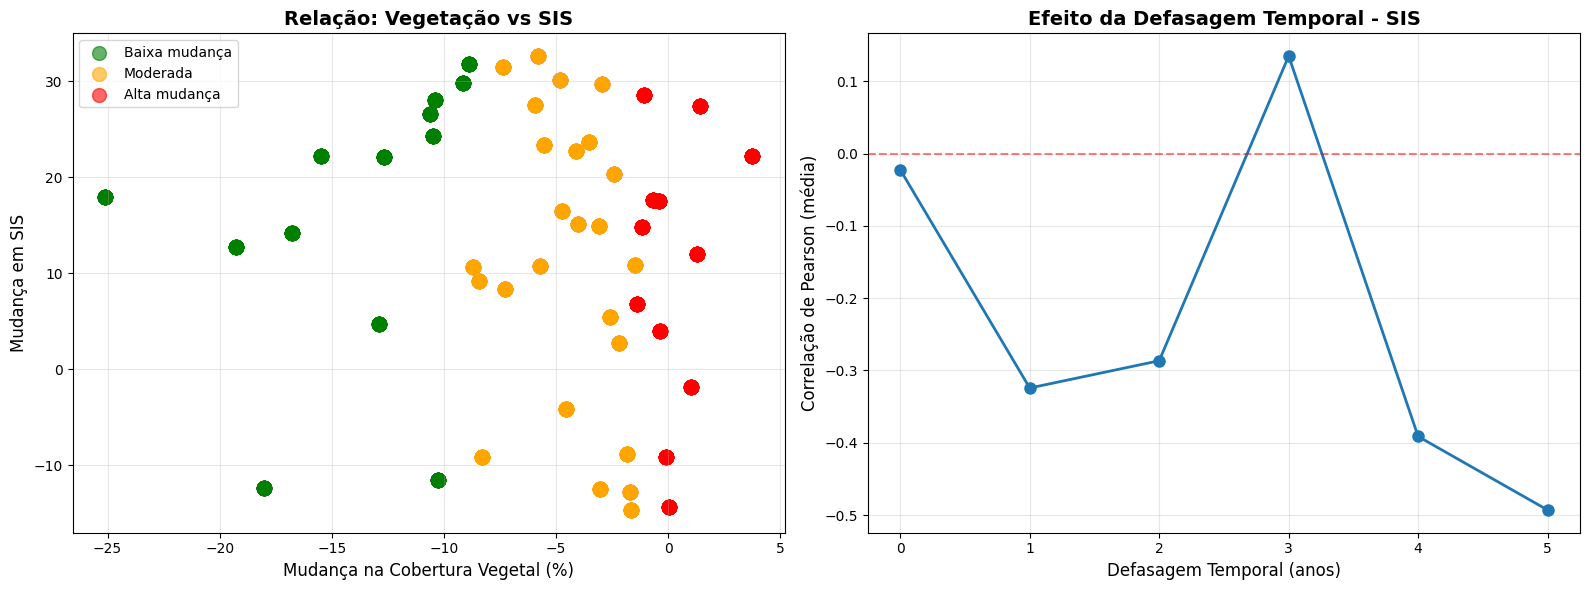

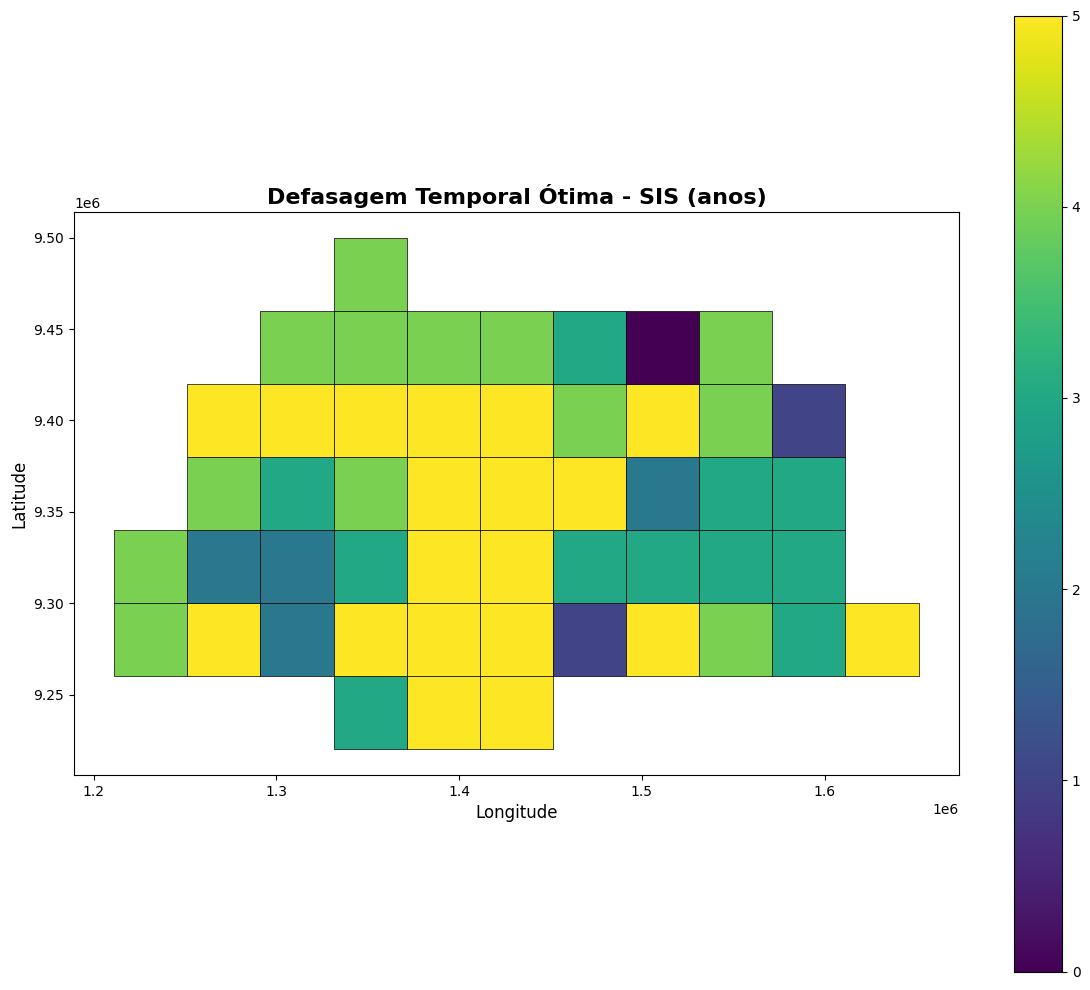


Análise completa com radiação solar incluída!


In [19]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.windows import Window
from shapely.geometry import box
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

def criar_grade_analise(shapefile_area, tamanho_celula_km=300):
    if isinstance(shapefile_area, str):
        gdf_area = gpd.read_file(shapefile_area)
    else:
        gdf_area = shapefile_area
    
    if not gdf_area.crs.is_projected:
        gdf_area = gdf_area.to_crs("EPSG:31983")
    
    bounds = gdf_area.total_bounds
    tamanho_celula_m = tamanho_celula_km * 250
    
    cells = []
    cell_id = 0
    
    x_coords = np.arange(bounds[0], bounds[2], tamanho_celula_m)
    y_coords = np.arange(bounds[1], bounds[3], tamanho_celula_m)
    
    for x in x_coords:
        for y in y_coords:
            cell = box(x, y, x + tamanho_celula_m, y + tamanho_celula_m)
            if gdf_area.intersects(cell).any():
                cells.append({
                    'cell_id': cell_id,
                    'geometry': cell
                })
                cell_id += 1
    
    grade = gpd.GeoDataFrame(cells, crs=gdf_area.crs)
    
    grade_wgs84 = grade.to_crs("EPSG:4326")
    grade['longitude'] = grade_wgs84.geometry.centroid.x
    grade['latitude'] = grade_wgs84.geometry.centroid.y
    
    print(f"Grade criada com {len(grade)} células de {tamanho_celula_km}x{tamanho_celula_km} km")
    
    return grade

def calcular_mudancas_cobertura_vegetal(raster_paths, grade, classes_vegetacao):
    resultados = []
    
    with rasterio.open(list(raster_paths.values())[0]) as src:
        grade_raster_crs = grade.to_crs(src.crs)
    
    for ano, raster_path in sorted(raster_paths.items()):
        print(f"Processando ano {ano}...")
        
        with rasterio.open(raster_path) as src:
            for idx, cell in grade_raster_crs.iterrows():
                try:
                    out_image, out_transform = mask(src, [cell.geometry], crop=True)
                    data = out_image[0]
                    
                    total_pixels = data.size
                    valid_pixels = np.sum(data != src.nodata) if src.nodata else total_pixels
                    
                    veg_pixels = np.sum(np.isin(data, classes_vegetacao))
                    
                    pct_vegetacao = (veg_pixels / valid_pixels * 100) if valid_pixels > 0 else 0
                    
                    classes_presentes = {}
                    for classe in classes_vegetacao:
                        count = np.sum(data == classe)
                        if count > 0:
                            classes_presentes[f'classe_{classe}'] = count
                    
                    resultados.append({
                        'cell_id': cell['cell_id'],
                        'ano': ano,
                        'longitude': cell['longitude'],
                        'latitude': cell['latitude'],
                        'pct_vegetacao': pct_vegetacao,
                        'pixels_vegetacao': veg_pixels,
                        'pixels_totais': valid_pixels,
                        **classes_presentes
                    })
                    
                except Exception as e:
                    print(f"Erro na célula {cell['cell_id']}, ano {ano}: {e}")
                    continue
    
    df_cobertura = pd.DataFrame(resultados)
    df_cobertura = calcular_taxa_mudanca(df_cobertura)
    
    return df_cobertura

def calcular_taxa_mudanca(df_cobertura):
    taxas = []
    
    for cell_id in df_cobertura['cell_id'].unique():
        df_cell = df_cobertura[df_cobertura['cell_id'] == cell_id].sort_values('ano')
        
        if len(df_cell) >= 2:
            anos = df_cell['ano'].values
            vegetacao = df_cell['pct_vegetacao'].values
            
            slope, intercept, r_value, p_value, std_err = stats.linregress(anos, vegetacao)
            
            mudanca_total = vegetacao[-1] - vegetacao[0]
            anos_total = anos[-1] - anos[0]
            
            taxas.append({
                'cell_id': cell_id,
                'taxa_mudanca_anual': slope,
                'mudanca_total': mudanca_total,
                'r_squared': r_value**2,
                'p_value': p_value,
                'anos_analisados': anos_total,
                'vegetacao_inicial': vegetacao[0],
                'vegetacao_final': vegetacao[-1]
            })
    
    df_taxas = pd.DataFrame(taxas)
    df_resultado = df_cobertura.merge(df_taxas, on='cell_id', how='left')
    
    return df_resultado

def calcular_mudancas_meteorologicas(df_meteo, grade, variavel='precipitation', col_time='data', col_lat='latitude', col_lon='longitude'):
    resultados = []
    df_meteo['ano'] = pd.to_datetime(df_meteo[col_time]).dt.year
    
    for idx, cell in grade.iterrows():
        buffer_deg = 0.5
        df_cell = df_meteo[
            (df_meteo[col_lon] >= cell['longitude'] - buffer_deg) &
            (df_meteo[col_lon] <= cell['longitude'] + buffer_deg) &
            (df_meteo[col_lat] >= cell['latitude'] - buffer_deg) &
            (df_meteo[col_lat] <= cell['latitude'] + buffer_deg)
        ]
        
        if len(df_cell) == 0:
            continue
        
        df_anual = df_cell.groupby('ano').agg({
            variavel: ['sum', 'mean', 'std', 'min', 'max', 'count']
        }).reset_index()
        
        df_anual.columns = ['ano', f'{variavel}_sum', f'{variavel}_mean',
                            f'{variavel}_std', f'{variavel}_min', f'{variavel}_max', 'n_obs']
        df_anual['cell_id'] = cell['cell_id']
        df_anual['longitude'] = cell['longitude']
        df_anual['latitude'] = cell['latitude']
        
        resultados.append(df_anual)
    
    if not resultados:
        raise ValueError("Nenhum dado meteorológico encontrado para as células da grade")
    
    df_meteo_grade = pd.concat(resultados, ignore_index=True)
    df_meteo_grade = calcular_taxa_mudanca_meteo(df_meteo_grade, variavel)
    
    return df_meteo_grade

def calcular_taxa_mudanca_meteo(df_meteo, variavel):
    taxas = []
    
    for cell_id in df_meteo['cell_id'].unique():
        df_cell = df_meteo[df_meteo['cell_id'] == cell_id].sort_values('ano')
        
        if len(df_cell) >= 2:
            anos = df_cell['ano'].values
            valores = df_cell[f'{variavel}_mean'].values
            
            slope, intercept, r_value, p_value, std_err = stats.linregress(anos, valores)
            
            mudanca_total = valores[-1] - valores[0]
            anos_total = anos[-1] - anos[0]
            
            taxas.append({
                'cell_id': cell_id,
                f'taxa_mudanca_{variavel}_anual': slope,
                f'mudanca_total_{variavel}': mudanca_total,
                f'r_squared_{variavel}': r_value**2,
                f'p_value_{variavel}': p_value,
                f'{variavel}_inicial': valores[0],
                f'{variavel}_final': valores[-1]
            })
    
    df_taxas = pd.DataFrame(taxas)
    df_resultado = df_meteo.merge(df_taxas, on='cell_id', how='left')
    
    return df_resultado

def analise_correlacao_com_lag(df_cobertura, df_meteo, variavel_meteo='precipitation', max_lag_anos=5):
    resultados_lag = []
    
    df_cob_agg = df_cobertura.groupby(['cell_id', 'ano']).agg({
        'pct_vegetacao': 'mean',
        'longitude': 'first',
        'latitude': 'first'
    }).reset_index()
    
    df_met_agg = df_meteo.groupby(['cell_id', 'ano']).agg({
        f'{variavel_meteo}_mean': 'mean'
    }).reset_index()
    
    for cell_id in df_cob_agg['cell_id'].unique():
        df_cob_cell = df_cob_agg[df_cob_agg['cell_id'] == cell_id].sort_values('ano')
        df_met_cell = df_met_agg[df_met_agg['cell_id'] == cell_id].sort_values('ano')
        
        if len(df_cob_cell) < 3 or len(df_met_cell) < 3:
            continue
        
        for lag in range(0, max_lag_anos + 1):
            df_cob_lagged = df_cob_cell.copy()
            df_cob_lagged['ano_lag'] = df_cob_lagged['ano'] + lag
            
            df_merged = df_cob_lagged.merge(
                df_met_cell,
                left_on='ano_lag',
                right_on='ano',
                suffixes=('_cob', '_met')
            )
            
            if len(df_merged) >= 3:
                corr_pearson, p_pearson = pearsonr(
                    df_merged['pct_vegetacao'],
                    df_merged[f'{variavel_meteo}_mean']
                )
                
                corr_spearman, p_spearman = spearmanr(
                    df_merged['pct_vegetacao'],
                    df_merged[f'{variavel_meteo}_mean']
                )
                
                resultados_lag.append({
                    'cell_id': cell_id,
                    'lag_anos': lag,
                    'n_obs': len(df_merged),
                    'corr_pearson': corr_pearson,
                    'p_value_pearson': p_pearson,
                    'corr_spearman': corr_spearman,
                    'p_value_spearman': p_spearman,
                    'longitude': df_cob_cell['longitude'].iloc[0],
                    'latitude': df_cob_cell['latitude'].iloc[0]
                })
    
    df_lag = pd.DataFrame(resultados_lag)
    idx = df_lag.groupby('cell_id')['corr_pearson'].apply(lambda x: x.abs().idxmax())
    df_best_lag = df_lag.loc[idx].reset_index(drop=True)
    
    return df_lag, df_best_lag

def analise_integrada(df_cobertura, df_meteo_list, grade):
    df_taxas = df_cobertura.groupby('cell_id').first().reset_index()
    
    q25, q75 = df_taxas['mudanca_total'].quantile([0.25, 0.75])
    
    df_taxas['categoria'] = 'Moderada'
    df_taxas.loc[df_taxas['mudanca_total'] <= q25, 'categoria'] = 'Baixa mudança'
    df_taxas.loc[df_taxas['mudanca_total'] >= q75, 'categoria'] = 'Alta mudança'
    
    print(f"\nDistribuição das células por categoria de mudança:")
    print(df_taxas['categoria'].value_counts())
    print(f"\nMudança total - Q25: {q25:.2f}%, Q75: {q75:.2f}%")
    
    resultados = {}
    
    for df_meteo, var_name in df_meteo_list:
        print(f"\n{'='*60}")
        print(f"Analisando variável: {var_name}")
        print('='*60)
        
        df_merged = df_meteo.merge(
            df_taxas[['cell_id', 'categoria', 'mudanca_total', 'taxa_mudanca_anual']],
            on='cell_id',
            how='inner'
        )
        
        print(f"\nComparação entre categorias para {var_name}:")
        for cat in ['Baixa mudança', 'Moderada', 'Alta mudança']:
            df_cat = df_merged[df_merged['categoria'] == cat]
            if len(df_cat) > 0:
                taxa_media = df_cat[f'taxa_mudanca_{var_name}_anual'].mean()
                mudanca_media = df_cat[f'mudanca_total_{var_name}'].mean()
                print(f"\n{cat}:")
                print(f"  Taxa anual média: {taxa_media:.4f}")
                print(f"  Mudança total média: {mudanca_media:.4f}")
        
        df_lag, df_best_lag = analise_correlacao_com_lag(
            df_cobertura, df_meteo, var_name, max_lag_anos=5
        )
        
        resultados[var_name] = {
            'df_merged': df_merged,
            'df_lag': df_lag,
            'df_best_lag': df_best_lag
        }
    
    return resultados, df_taxas

def plotar_resultados(resultados, df_taxas, grade, output_dir='./resultados'):
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    grade_plot = grade.merge(df_taxas[['cell_id', 'mudanca_total']], on='cell_id')
    grade_plot.plot(column='mudanca_total', cmap='RdYlGn', legend=True,
                    ax=ax, edgecolor='black', linewidth=0.5)
    ax.set_title('Mudança Total na Cobertura Vegetal (%)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/mapa_mudanca_vegetacao.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    for var_name, dados in resultados.items():
        df_merged = dados['df_merged']
        df_lag = dados['df_lag']
        df_best_lag = dados['df_best_lag']
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        for cat, color in zip(['Baixa mudança', 'Moderada', 'Alta mudança'],
                               ['green', 'orange', 'red']):
            df_cat = df_merged[df_merged['categoria'] == cat]
            if len(df_cat) > 0:
                axes[0].scatter(df_cat['mudanca_total'], 
                               df_cat[f'mudanca_total_{var_name}'],
                               c=color, label=cat, alpha=0.6, s=100)
        
        axes[0].set_xlabel('Mudança na Cobertura Vegetal (%)', fontsize=12)
        axes[0].set_ylabel(f'Mudança em {var_name}', fontsize=12)
        axes[0].set_title(f'Relação: Vegetação vs {var_name}', fontsize=14, fontweight='bold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        df_lag_summary = df_lag.groupby('lag_anos').agg({
            'corr_pearson': 'mean',
            'p_value_pearson': 'mean'
        }).reset_index()
        
        axes[1].plot(df_lag_summary['lag_anos'], df_lag_summary['corr_pearson'],
                     marker='o', linewidth=2, markersize=8)
        axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        axes[1].set_xlabel('Defasagem Temporal (anos)', fontsize=12)
        axes[1].set_ylabel('Correlação de Pearson (média)', fontsize=12)
        axes[1].set_title(f'Efeito da Defasagem Temporal - {var_name}', 
                         fontsize=14, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/analise_{var_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        fig, ax = plt.subplots(figsize=(12, 10))
        grade_lag = grade.merge(df_best_lag[['cell_id', 'lag_anos']], on='cell_id')
        grade_lag.plot(column='lag_anos', cmap='viridis', legend=True,
                      ax=ax, edgecolor='black', linewidth=0.5)
        ax.set_title(f'Defasagem Temporal Ótima - {var_name} (anos)', 
                    fontsize=16, fontweight='bold')
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/mapa_lag_{var_name}.png', dpi=300, bbox_inches='tight')
        plt.show()

if __name__ == "__main__":
    
    CLASSES_VEGETACAO = [1, 3, 4, 5, 6, 9, 10, 11, 49, 50]
    
    shapefile_brasil = r"F:\Mestrado\Dados_INMET\shapefiles\lml_unidade_federacao_a.shp"
    
    print("Carregando shapefile do Brasil e filtrando Rio Grande do Norte...")
    gdf_brasil = gpd.read_file(shapefile_brasil)
    gdf_rn = gdf_brasil[gdf_brasil['sigla'] == 'RN'].copy()
    
    if len(gdf_rn) == 0:
        raise ValueError("Estado 'RN' não encontrado no shapefile. Verifique a coluna 'sigla'.")
    
    print(f"Estado encontrado: {gdf_rn['sigla'].iloc[0]}")
    print(f"CRS original: {gdf_rn.crs}")
    
    grade = criar_grade_analise(gdf_rn, tamanho_celula_km=100)
    
    grade.to_file("grade_analise_RN.shp")
    print(f"\nGrade salva em: grade_analise_RN.shp")
    print(f"Total de células criadas: {len(grade)}")
    
    rasters_mapbiomas = {
        1990: r"F:\mapbiomas\RN_1990_lclu_recortado.tif",
        2000: r"F:\mapbiomas\RN_2000_lclu_recortado.tif",
        2010: r"F:\mapbiomas\RN_2010_lclu_recortado.tif",
        2020: r"F:\mapbiomas\RN_2020_lclu_recortado.tif"
    }
    df_cobertura = calcular_mudancas_cobertura_vegetal(
        rasters_mapbiomas, grade, CLASSES_VEGETACAO
    )
    df_cobertura.to_csv("dados_cobertura_vegetal.csv", index=False)
    
    df_chirps = pd.read_parquet(r"F:\rn\CHIRPS_RN_diaria_por_pixel_1990_2024.parquet")
    df_meteo_precip = calcular_mudancas_meteorologicas(
        df_chirps, grade, variavel='precipitation', col_time='data', col_lat='latitude', col_lon='longitude'
    )
    df_meteo_precip.to_parquet("dados_meteorologicos_precipitacao.parquet", index=False)
    
    df_era5_temp = pd.read_parquet(r"F:\rn\ERA5_TemperaturaMedia_RN_1990_2024.parquet")
    df_meteo_temp = calcular_mudancas_meteorologicas(
        df_era5_temp, grade, variavel='temp_celsius', col_time='data', col_lat='latitude', col_lon='longitude'
    )
    df_meteo_temp.to_parquet("dados_meteorologicos_temperatura.parquet", index=False)
    
    print("\nProcessando dados de radiação solar...")
    df_sis = pd.read_parquet(r"F:\rn\SIS_RN.parquet")
    df_meteo_sis = calcular_mudancas_meteorologicas(
        df_sis, grade, variavel='SIS', col_time='time', col_lat='lat', col_lon='lon'
    )
    df_meteo_sis.to_parquet("dados_meteorologicos_radiacao.parquet", index=False)
    
    df_meteo_list = [
        (df_meteo_precip, 'precipitation'),
        (df_meteo_temp, 'temp_celsius'),
        (df_meteo_sis, 'SIS')
    ]
    resultados, df_taxas = analise_integrada(df_cobertura, df_meteo_list, grade)
    
    plotar_resultados(resultados, df_taxas, grade, output_dir='./resultados')
    
    print("\nAnálise completa com radiação solar incluída!")

In [13]:
# Identificar célula com menor e maior mudança de vegetação
cell_menor = df_taxas.loc[df_taxas['mudanca_total'].idxmin(), 'cell_id']
cell_maior = df_taxas.loc[df_taxas['mudanca_total'].idxmax(), 'cell_id']

print(f"Célula com MENOR mudança: {cell_menor}")
print(f"Célula com MAIOR mudança: {cell_maior}")

# Filtrar série histórica dessas células
serie_menor = df_cobertura[df_cobertura['cell_id'] == cell_menor].sort_values('ano')
serie_maior = df_cobertura[df_cobertura['cell_id'] == cell_maior].sort_values('ano')

print("\nSérie histórica - MENOR mudança:")
print(serie_menor[['ano', 'pct_vegetacao']])

print("\nSérie histórica - MAIOR mudança:")
print(serie_maior[['ano', 'pct_vegetacao']])


Célula com MENOR mudança: 10
Célula com MAIOR mudança: 7

Série histórica - MENOR mudança:
      ano  pct_vegetacao
10   1990      78.217068
61   2000      71.767533
112  2010      64.691739
163  2020      53.100879

Série histórica - MAIOR mudança:
      ano  pct_vegetacao
7    1990      62.115696
58   2000      59.638470
109  2010      70.564259
160  2020      65.869039


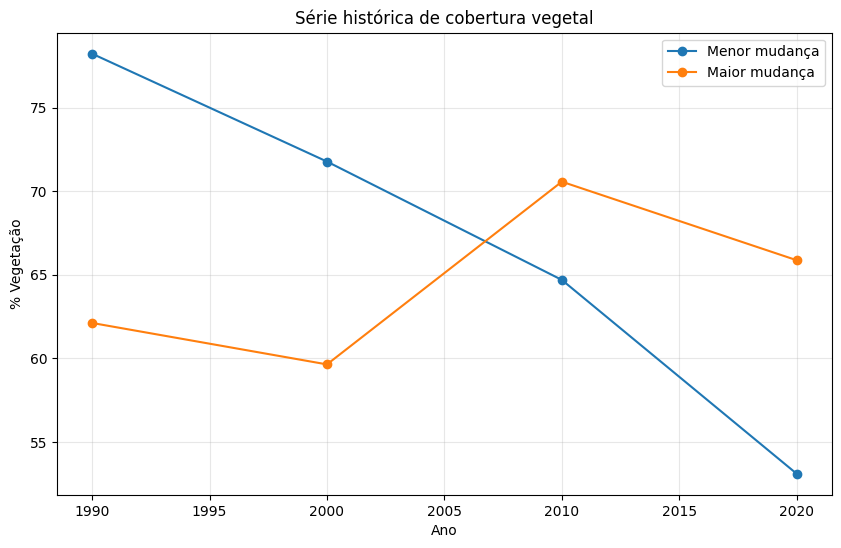

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(serie_menor['ano'], serie_menor['pct_vegetacao'], marker='o', label='Menor mudança')
plt.plot(serie_maior['ano'], serie_maior['pct_vegetacao'], marker='o', label='Maior mudança')
plt.xlabel("Ano")
plt.ylabel("% Vegetação")
plt.title("Série histórica de cobertura vegetal")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


IndexError: invalid index to scalar variable.

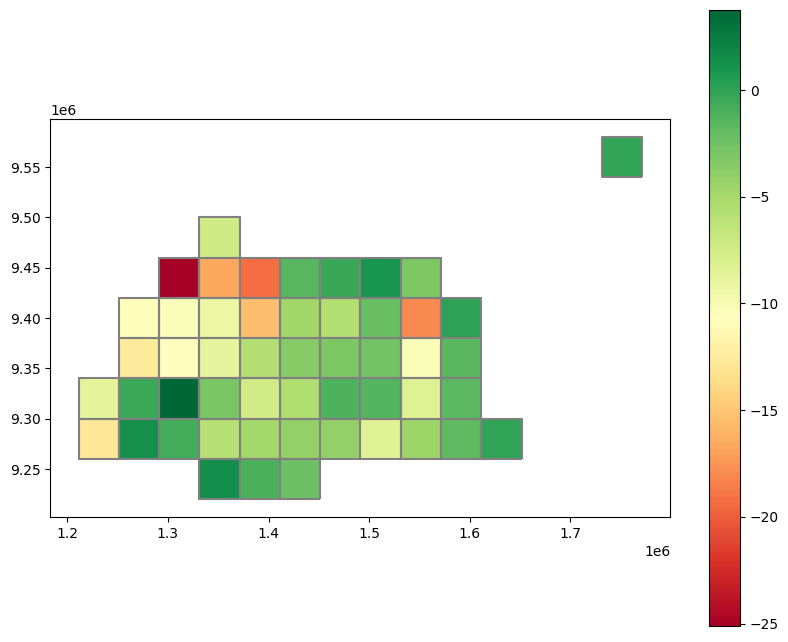

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
grade.boundary.plot(ax=ax, color="gray")

# toda a grade colorida pela mudança
grade_plot = grade.merge(df_taxas[['cell_id','mudanca_total']], on='cell_id')
grade_plot.plot(column='mudanca_total', cmap='RdYlGn', ax=ax, legend=True)

# destacar menor mudança em azul
grade_plot[grade_plot['cell_id'] == cell_menor['cell_id']].plot(ax=ax, facecolor="blue", edgecolor="black")

# destacar maior mudança em red
grade_plot[grade_plot['cell_id'] == cell_maior['cell_id']].plot(ax=ax, facecolor="red", edgecolor="black")

ax.set_title("Maior (vermelho) e menor (azul) mudança de vegetação")
plt.show()


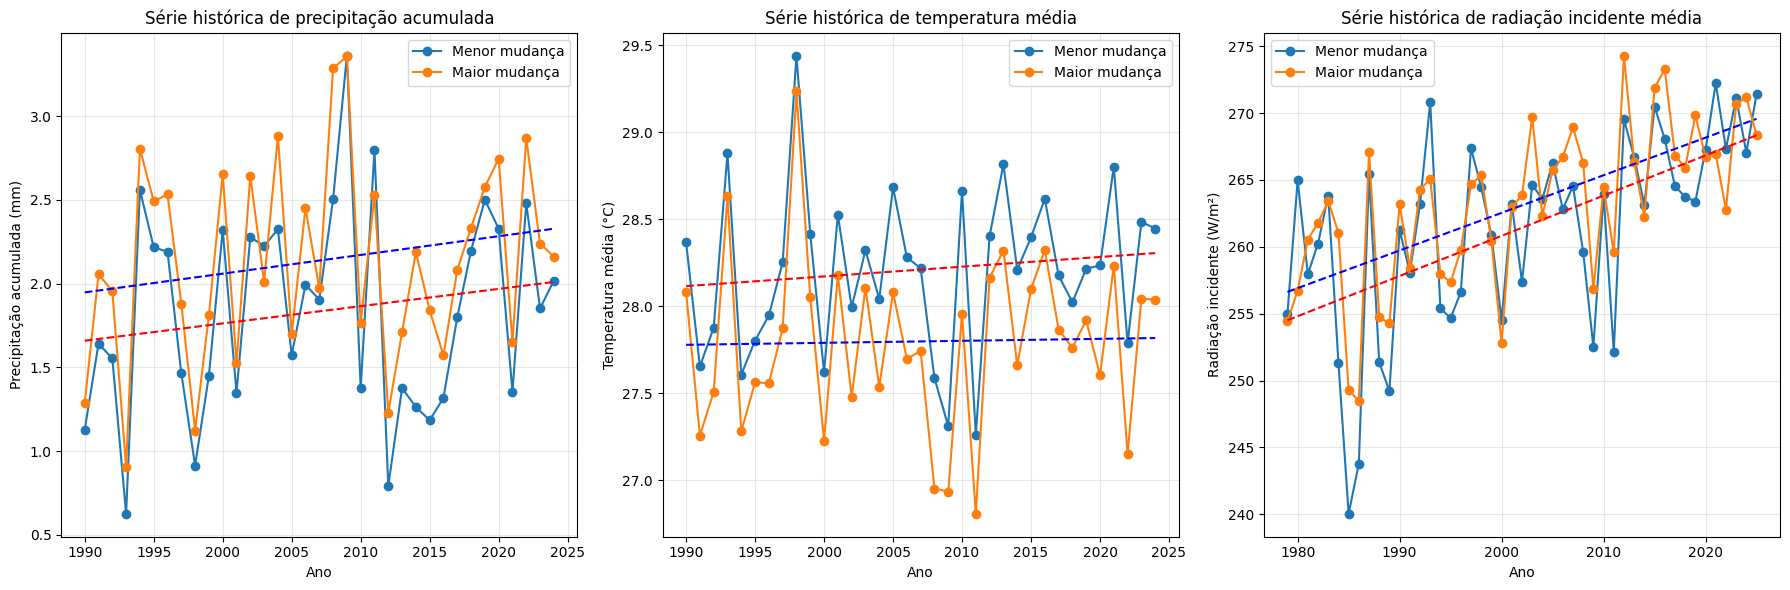

In [179]:
import numpy as np
import matplotlib.pyplot as plt

cell_menor = df_taxas.loc[df_taxas['mudanca_total'].idxmin(), 'cell_id']
cell_maior = df_taxas.loc[df_taxas['mudanca_total'].idxmax(), 'cell_id']

serie_precip_menor = df_meteo_precip[df_meteo_precip['cell_id'] == cell_menor].sort_values('ano')
serie_precip_maior = df_meteo_precip[df_meteo_precip['cell_id'] == cell_maior].sort_values('ano')

serie_temp_menor = df_meteo_temp[df_meteo_temp['cell_id'] == cell_menor].sort_values('ano')
serie_temp_maior = df_meteo_temp[df_meteo_temp['cell_id'] == cell_maior].sort_values('ano')

serie_sis_menor = df_meteo_sis[df_meteo_sis['cell_id'] == cell_menor].sort_values('ano')
serie_sis_maior = df_meteo_sis[df_meteo_sis['cell_id'] == cell_maior].sort_values('ano')

fig, axes = plt.subplots(1, 3, figsize=(18,6))

axes[0].plot(serie_precip_menor['ano'], serie_precip_menor['precipitation_mean'], marker='o', label='Menor mudança')
axes[0].plot(serie_precip_maior['ano'], serie_precip_maior['precipitation_mean'], marker='o', label='Maior mudança')
coef = np.polyfit(serie_precip_menor['ano'], serie_precip_menor['precipitation_mean'], 1)
axes[0].plot(serie_precip_menor['ano'], np.poly1d(coef)(serie_precip_menor['ano']), linestyle='--', color='red')
coef2 = np.polyfit(serie_precip_maior['ano'], serie_precip_maior['precipitation_mean'], 1)
axes[0].plot(serie_precip_maior['ano'], np.poly1d(coef2)(serie_precip_maior['ano']), linestyle='--', color='blue')
axes[0].set_title("Série histórica de precipitação acumulada")
axes[0].set_xlabel("Ano")
axes[0].set_ylabel("Precipitação acumulada (mm)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(serie_temp_menor['ano'], serie_temp_menor['temp_celsius_mean'], marker='o', label='Menor mudança')
axes[1].plot(serie_temp_maior['ano'], serie_temp_maior['temp_celsius_mean'], marker='o', label='Maior mudança')
coef = np.polyfit(serie_temp_menor['ano'], serie_temp_menor['temp_celsius_mean'], 1)
axes[1].plot(serie_temp_menor['ano'], np.poly1d(coef)(serie_temp_menor['ano']), linestyle='--', color='red')
coef2 = np.polyfit(serie_temp_maior['ano'], serie_temp_maior['temp_celsius_mean'], 1)
axes[1].plot(serie_temp_maior['ano'], np.poly1d(coef2)(serie_temp_maior['ano']), linestyle='--', color='blue')
axes[1].set_title("Série histórica de temperatura média")
axes[1].set_xlabel("Ano")
axes[1].set_ylabel("Temperatura média (°C)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(serie_sis_menor['ano'], serie_sis_menor['SIS_mean'], marker='o', label='Menor mudança')
axes[2].plot(serie_sis_maior['ano'], serie_sis_maior['SIS_mean'], marker='o', label='Maior mudança')
coef = np.polyfit(serie_sis_menor['ano'], serie_sis_menor['SIS_mean'], 1)
axes[2].plot(serie_sis_menor['ano'], np.poly1d(coef)(serie_sis_menor['ano']), linestyle='--', color='red')
coef2 = np.polyfit(serie_sis_maior['ano'], serie_sis_maior['SIS_mean'], 1)
axes[2].plot(serie_sis_maior['ano'], np.poly1d(coef2)(serie_sis_maior['ano']), linestyle='--', color='blue')
axes[2].set_title("Série histórica de radiação incidente média")
axes[2].set_xlabel("Ano")
axes[2].set_ylabel("Radiação incidente (W/m²)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


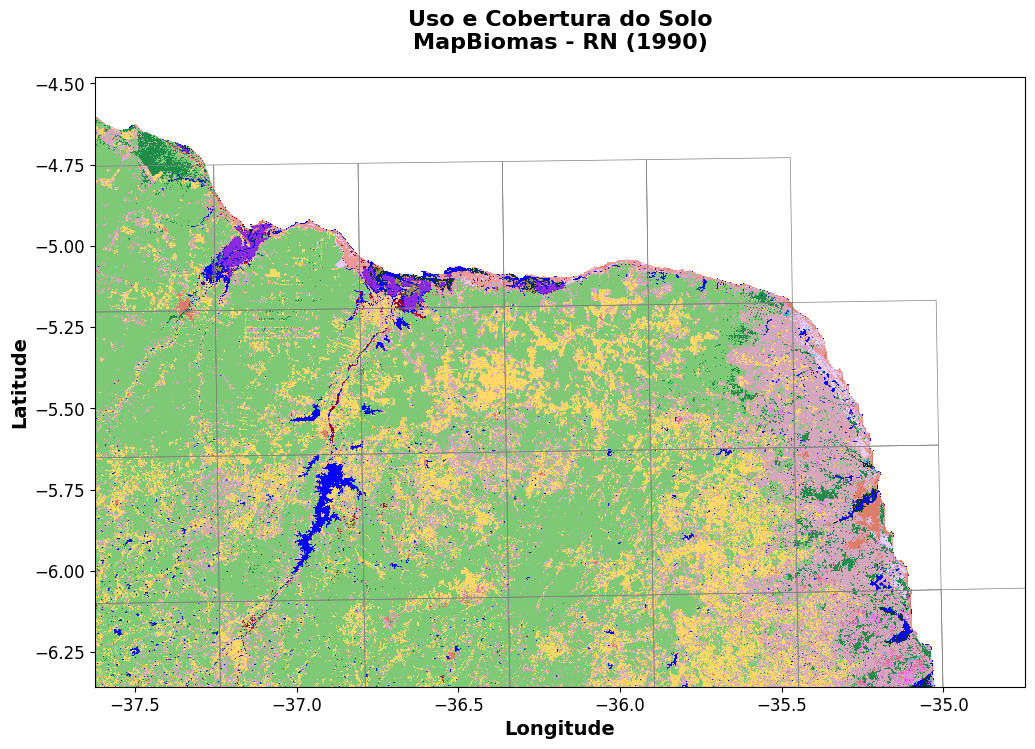


Classes presentes no raster (com máscara aplicada):
------------------------------------------------------------
Classe  3 | Formação Florestal                  |   1.49%
Classe  4 | Formação Savânica                   |  27.28%
Classe  5 | Mangue                              |   0.10%
Classe  9 | Formação Campestre                  |   0.00%
Classe 11 | Campo Alagado e Área Pantanosa      |   0.05%
Classe 12 | Apicum                              |   0.01%
Classe 15 | Pastagem                            |  10.28%
Classe 20 | Cana                                |   0.30%
Classe 21 | Mosaico de Usos                     |   9.45%
Classe 23 | Praia, Duna e Areal                 |   0.30%
Classe 24 | Área Urbanizada                     |   0.31%
Classe 25 | Outras Áreas não Vegetadas          |   0.14%
Classe 29 | Afloramento Rochoso                 |   0.03%
Classe 30 | Mineração                           |   0.00%
Classe 31 | Aquicultura                         |   0.14%
Classe 32 | Sal 

In [121]:
import geopandas as gpd
import rasterio
from affine import Affine
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import os

tif = r"C:\Users\camil\Downloads\mapbiomas\RN_1990_lclu_recortado.tif"
grade_path = r"grade_analise_RN.shp"
output_map = r"C:\Users\camil\Downloads\imagens\RN_1990_lclu_mapbiomas_zoom.png"

colors = {
    0: "#ffffff", 1: "#129912", 3: "#1f8d49", 4: "#7dc975", 5: "#04381d",
    6: "#026975", 9: "#ad5100", 10: "#bbfcac", 11: "#45c2a5", 12: "#b8af4f",
    13: "#f1c232", 14: "#ffffb2", 15: "#ffd966", 18: "#f6b26b", 19: "#f99f40",
    20: "#e974ed", 21: "#d5a6bd", 22: "#c27ba0", 23: "#ea9999", 24: "#dd7e6b",
    25: "#aa0000", 26: "#0000ff", 27: "#d5d5e5", 29: "#935132", 30: "#af2a2a",
    31: "#8a2be2", 32: "#968c46", 33: "#0000ff", 36: "#02d659", 39: "#ad5100",
    40: "#ff69b4", 41: "#db7093", 46: "#91d1aa", 47: "#c59f57", 48: "#d082de",
    49: "#cd49e4", 50: "#e6ccff", 62: "#9c0027"
}

labels = {
    0: "Não observado", 1: "Floresta", 3: "Formação Florestal", 4: "Formação Savânica",
    5: "Mangue", 6: "Floresta Inundável", 9: "Formação Campestre", 10: "Afloramento Rochoso",
    11: "Campo Alagado e Área Pantanosa", 12: "Apicum", 13: "Outras Formações não Florestais",
    14: "Agropecuária", 15: "Pastagem", 18: "Agricultura", 19: "Lavoura Temporária",
    20: "Cana", 21: "Mosaico de Usos", 22: "Área não Vegetada", 23: "Praia, Duna e Areal",
    24: "Área Urbanizada", 25: "Outras Áreas não Vegetadas", 26: "Corpo D'água",
    27: "Não observado", 29: "Afloramento Rochoso", 30: "Mineração", 31: "Aquicultura",
    32: "Sal", 33: "Rio, Lago e Oceano", 36: "Lavoura Perene", 39: "Soja", 40: "Arroz",
    41: "Outras Lavouras Temporárias", 46: "Café", 47: "Citrus", 48: "Outras Lavouras Perenes",
    49: "Floresta Plantada", 50: "Restinga Arborizada", 62: "Algodão (beta)"
}

fator = 5
with rasterio.open(tif) as src:
    out_shape = (src.height // fator, src.width // fator)
    data = src.read(1, out_shape=out_shape, resampling=rasterio.enums.Resampling.nearest)
    scale_x = src.width / float(data.shape[1])
    scale_y = src.height / float(data.shape[0])
    new_transform = src.transform * Affine.scale(scale_x, scale_y)
    minx, miny, maxx, maxy = rasterio.transform.array_bounds(data.shape[0], data.shape[1], new_transform)
    extent = (minx, maxx, miny, maxy)
    raster_crs = src.crs
    nodata = src.nodata

mask = data != nodata if nodata is not None else data != 0
vals = np.sort(np.unique(data[mask]))
relabeled = np.full_like(data, np.nan, dtype=float)
mapping = {v: i for i, v in enumerate(vals)}
for v in vals:
    relabeled[data == v] = mapping[v]
cmap_colors = [colors.get(v, "#cccccc") for v in vals]
cmap = ListedColormap(cmap_colors)

grade = gpd.read_file(grade_path).to_crs(raster_crs)
grade = grade.cx[minx:maxx, miny:maxy]
grade = grade.iloc[::1]

zoom_factor = 0.2
largura = maxx - minx
altura = maxy - miny
xmin = minx + largura * zoom_factor
xmax = maxx - largura * zoom_factor
ymin = miny + altura * zoom_factor
ymax = maxy - altura * zoom_factor

fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(relabeled, cmap=cmap, extent=extent, interpolation='nearest', origin='upper')
grade.boundary.plot(ax=ax, edgecolor="gray", linewidth=0.5)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel("Longitude", fontsize=14, fontweight='bold')
ax.set_ylabel("Latitude", fontsize=14, fontweight='bold')
ax.set_title("Uso e Cobertura do Solo\nMapBiomas - RN (1990)", fontsize=16, fontweight='bold', pad=20)
ax.tick_params(labelsize=12)

os.makedirs(os.path.dirname(output_map), exist_ok=True)
plt.savefig(output_map, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\nClasses presentes no raster (com máscara aplicada):")
print("-" * 60)
total_pixels = data.size
for v in sorted(vals):
    count = np.sum(data == v)
    percent = (count / total_pixels) * 100
    print(f"Classe {int(v):2d} | {labels.get(int(v), 'Desconhecido'):35s} | {percent:6.2f}%")

In [56]:
import pandas as pd
import rasterio
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os

minx, miny, maxx, maxy = -38.72, -7.08, -34.89, -4.72
grid_size_deg = 0.5

chirps_path = r"F:\rn\CHIRPS_RN_diaria_por_pixel_1990_2024.parquet"
era5_path = r"F:\rn\ERA5_TemperaturaMedia_RN_1990_2024.parquet"

mapbiomas_paths = {
    1990: r"F:\mapbiomas\RN_1990_lclu_recortado.tif",
    2000: r"F:\mapbiomas\RN_2000_lclu_recortado.tif",
    2010: r"F:\mapbiomas\RN_2010_lclu_recortado.tif",
    2020: r"F:\mapbiomas\RN_2020_lclu_recortado.tif"
}

x_bins = np.arange(minx, maxx + grid_size_deg, grid_size_deg)
y_bins = np.arange(miny, maxy + grid_size_deg, grid_size_deg)
nx = len(x_bins) - 1
ny = len(y_bins) - 1

def lonlat_to_grid(lon, lat):
    gx = ((lon - minx) // grid_size_deg).astype(int)
    gy = ((lat - miny) // grid_size_deg).astype(int)
    return gx * ny + gy

veg_records = []

for year, tif_path in mapbiomas_paths.items():
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        nodata = src.nodata
        transform = src.transform
        for gx in range(nx):
            for gy in range(ny):
                lon0 = minx + gx * grid_size_deg
                lon1 = lon0 + grid_size_deg
                lat0 = miny + gy * grid_size_deg
                lat1 = lat0 + grid_size_deg
                r0, c0 = ~transform * (lon0, lat1)
                r1, c1 = ~transform * (lon1, lat0)
                r0, r1 = int(max(0, min(r0, r1))), int(min(data.shape[0], max(r0, r1)))
                c0, c1 = int(max(0, min(c0, c1))), int(min(data.shape[1], max(c0, c1)))
                sub = data[r0:r1, c0:c1]
                if sub.size == 0:
                    veg = np.nan
                else:
                    if nodata is not None:
                        sub = sub[sub != nodata]
                    if sub.size == 0:
                        veg = np.nan
                    else:
                        veg = np.sum(sub == 3) / sub.size * 100
                veg_records.append({
                    "grid_id": gx * ny + gy,
                    "year": year,
                    "veg_perc": veg
                })

veg_df = pd.DataFrame(veg_records)

defor_df = (
    veg_df
    .dropna()
    .sort_values("year")
    .groupby("grid_id")
    .agg(veg_initial=("veg_perc", "first"),
         veg_final=("veg_perc", "last"),
         year_initial=("year", "first"),
         year_final=("year", "last"))
    .reset_index()
)

defor_df["defor_perc"] = defor_df["veg_initial"] - defor_df["veg_final"]
defor_df["defor_rate"] = defor_df["defor_perc"] / (defor_df["year_final"] - defor_df["year_initial"])

chirps_df = pd.read_parquet(
    chirps_path,
    columns=["date", "longitude", "latitude", "precipitation"]
)
era5_df = pd.read_parquet(
    era5_path,
    columns=["date", "longitude", "latitude", "temp_celsius"]
)

chirps_df["date"] = pd.to_datetime(chirps_df["date"])
era5_df["date"] = pd.to_datetime(era5_df["date"])

dry_months = [6, 7, 8, 9, 10, 11, 12]

chirps_df = chirps_df[chirps_df["date"].dt.month.isin(dry_months)]
era5_df = era5_df[era5_df["date"].dt.month.isin(dry_months)]

chirps_df["year"] = chirps_df["date"].dt.year
era5_df["year"] = era5_df["date"].dt.year

chirps_df["grid_id"] = lonlat_to_grid(chirps_df["longitude"], chirps_df["latitude"])
era5_df["grid_id"] = lonlat_to_grid(era5_df["longitude"], era5_df["latitude"])

annual_precip = (
    chirps_df
    .groupby(["grid_id", "year"], as_index=False)
    .agg(dry_precip=("precipitation", "sum"))
)

annual_temp = (
    era5_df
    .groupby(["grid_id", "year"], as_index=False)
    .agg(dry_mean_temp=("temp_celsius", "mean"),
         dry_max_temp=("temp_celsius", "max"))
)

trend_rows = []

for grid_id, df_p in annual_precip.groupby("grid_id"):
    df_t = annual_temp[annual_temp["grid_id"] == grid_id]
    if len(df_p) > 10 and len(df_t) > 10:
        p = linregress(df_p["year"], df_p["dry_precip"])
        tm = linregress(df_t["year"], df_t["dry_mean_temp"])
        tx = linregress(df_t["year"], df_t["dry_max_temp"])
        trend_rows.append({
            "grid_id": grid_id,
            "precip_trend": p.slope,
            "precip_r": p.rvalue,
            "precip_p": p.pvalue,
            "temp_mean_trend": tm.slope,
            "temp_mean_r": tm.rvalue,
            "temp_mean_p": tm.pvalue,
            "temp_max_trend": tx.slope,
            "temp_max_r": tx.rvalue,
            "temp_max_p": tx.pvalue
        })

trend_df = pd.DataFrame(trend_rows)

analysis_df = defor_df.merge(trend_df, on="grid_id")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(analysis_df["defor_perc"], analysis_df["precip_trend"])
axes[1].scatter(analysis_df["defor_perc"], analysis_df["temp_mean_trend"])
axes[2].scatter(analysis_df["defor_perc"], analysis_df["temp_max_trend"])
plt.tight_layout()
plt.show()

fit_rows = []
min_year = 1990

for grid_id, df_t in annual_temp.groupby("grid_id"):
    veg_sub = veg_df[veg_df["grid_id"] == grid_id].dropna()
    if veg_sub.empty:
        continue
    for _, row in df_t.iterrows():
        year = row["year"]
        closest = veg_sub.iloc[(veg_sub["year"] - year).abs().argmin()]
        D = 100 - closest["veg_perc"] + 0.01
        t = year - min_year
        fit_rows.append([D, t, row["dry_max_temp"]])

fit_df = pd.DataFrame(fit_rows, columns=["D", "t", "y"])

def model(X, a, b, c, d):
    D, t = X
    return np.log(D) * (a * t + b) + c * t + d

popt, _ = curve_fit(model, (fit_df["D"], fit_df["t"]), fit_df["y"])

analysis_df.to_csv("rn_analysis.csv", index=False)


ArrowInvalid: No match for FieldRef.Name(date) in data: string
precipitation: double
longitude: double
latitude: double
__fragment_index: int32
__batch_index: int32
__last_in_fragment: bool
__filename: string

In [47]:
# shapefile_path = pd.read_parquet(r"F:\Mestrado\Dados_INMET\shapefiles\lml_unidade_federacao_a.shp")
chirps_path = pd.read_parquet(r"F:\rn\CHIRPS_RN_diaria_por_pixel_1990_2024.parquet")
era5_path = pd.read_parquet(r"F:\rn\ERA5_TemperaturaMedia_RN_1990_2024.parquet")

In [49]:
chirps_path

,data,precipitation,longitude,latitude
0,1990-01-01,0.0,-38.574353,-4.875251
1,1990-01-01,0.0,-38.524353,-4.875251
2,1990-01-01,0.0,-38.474353,-4.875251
3,1990-01-01,0.0,-38.424352,-4.875251
4,1990-01-01,0.0,-38.374352,-4.875251
...,...,...,...,...
36521026,2024-12-30,0.0,-35.124337,-6.975261
36521027,2024-12-30,0.0,-35.074337,-6.975261
36521028,2024-12-30,0.0,-35.024337,-6.975261
36521029,2024-12-30,0.0,-34.974337,-6.975261


In [51]:
era5_path

,data,temp_celsius,longitude,latitude
0,1990-01-01,26.873933,-38.524919,-4.906417
1,1990-01-01,27.131746,-38.444070,-4.906417
2,1990-01-01,27.131746,-38.363222,-4.906417
3,1990-01-01,27.278238,-38.282373,-4.906417
4,1990-01-01,27.288980,-38.201525,-4.906417
...,...,...,...,...
13166485,2024-12-30,27.210519,-35.290984,-6.927626
13166486,2024-12-30,27.195985,-35.210135,-6.927626
13166487,2024-12-30,27.005983,-35.129287,-6.927626
13166488,2024-12-30,26.903879,-35.048438,-6.927626


In [33]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

def criar_grade_analise(shapefile_area, tamanho_celula_km=300):
    if isinstance(shapefile_area, str):
        gdf_area = gpd.read_file(shapefile_area)
    else:
        gdf_area = shapefile_area
    if not gdf_area.crs.is_projected:
        gdf_area = gdf_area.to_crs("EPSG:31983")
    bounds = gdf_area.total_bounds
    tamanho_celula_m = tamanho_celula_km * 1000
    cells = []
    cell_id = 0
    x_coords = np.arange(bounds[0], bounds[2], tamanho_celula_m)
    y_coords = np.arange(bounds[1], bounds[3], tamanho_celula_m)
    for x in x_coords:
        for y in y_coords:
            cell = box(x, y, x + tamanho_celula_m, y + tamanho_celula_m)
            if gdf_area.intersects(cell).any():
                cells.append({'cell_id': cell_id, 'geometry': cell})
                cell_id += 1
    grade = gpd.GeoDataFrame(cells, crs=gdf_area.crs)
    grade_wgs84 = grade.to_crs("EPSG:4326")
    grade['longitude'] = grade_wgs84.geometry.centroid.x
    grade['latitude'] = grade_wgs84.geometry.centroid.y
    return grade

def calcular_mudancas_cobertura_vegetal(raster_paths, grade, classes_vegetacao):
    resultados = []
    with rasterio.open(list(raster_paths.values())[0]) as src:
        grade_raster_crs = grade.to_crs(src.crs)
    for ano, raster_path in sorted(raster_paths.items()):
        with rasterio.open(raster_path) as src:
            for idx, cell in grade_raster_crs.iterrows():
                try:
                    out_image, out_transform = mask(src, [cell.geometry], crop=True)
                    data = out_image[0]
                    total_pixels = data.size
                    valid_pixels = np.sum(data != src.nodata) if src.nodata else total_pixels
                    veg_pixels = np.sum(np.isin(data, classes_vegetacao))
                    pct_vegetacao = (veg_pixels / valid_pixels * 100) if valid_pixels > 0 else 0
                    classes_presentes = {}
                    for classe in classes_vegetacao:
                        count = np.sum(data == classe)
                        if count > 0:
                            classes_presentes[f'classe_{classe}'] = count
                    resultados.append({
                        'cell_id': cell['cell_id'],
                        'ano': ano,
                        'longitude': cell['longitude'],
                        'latitude': cell['latitude'],
                        'pct_vegetacao': pct_vegetacao,
                        'pixels_vegetacao': veg_pixels,
                        'pixels_totais': valid_pixels,
                        **classes_presentes
                    })
                except:
                    continue
    df_cobertura = pd.DataFrame(resultados)
    df_cobertura = calcular_taxa_mudanca(df_cobertura)
    return df_cobertura

def calcular_taxa_mudanca(df_cobertura):
    taxas = []
    for cell_id in df_cobertura['cell_id'].unique():
        df_cell = df_cobertura[df_cobertura['cell_id'] == cell_id].sort_values('ano')
        if len(df_cell) >= 2:
            anos = df_cell['ano'].values
            vegetacao = df_cell['pct_vegetacao'].values
            slope, intercept, r_value, p_value, std_err = stats.linregress(anos, vegetacao)
            mudanca_total = vegetacao[-1] - vegetacao[0]
            anos_total = anos[-1] - anos[0]
            taxas.append({
                'cell_id': cell_id,
                'taxa_mudanca_anual': slope,
                'mudanca_total': mudanca_total,
                'r_squared': r_value**2,
                'p_value': p_value,
                'anos_analisados': anos_total,
                'vegetacao_inicial': vegetacao[0],
                'vegetacao_final': vegetacao[-1]
            })
    df_taxas = pd.DataFrame(taxas)
    df_resultado = df_cobertura.merge(df_taxas, on='cell_id', how='left')
    return df_resultado

def converter_grade_para_wgs84(grade):
    grade_wgs84 = grade.to_crs("EPSG:4326")
    grade['longitude'] = grade_wgs84.geometry.centroid.x
    grade['latitude'] = grade_wgs84.geometry.centroid.y
    return grade


In [35]:
def calcular_mudancas_meteorologicas(df_meteo, grade, variavel='precipitation'):
    resultados = []
    df_meteo['ano'] = pd.to_datetime(df_meteo['data']).dt.year
    for idx, cell in grade.iterrows():
        buffer_deg = 0.5
        df_cell = df_meteo[
            (df_meteo['longitude'] >= cell['longitude'] - buffer_deg) &
            (df_meteo['longitude'] <= cell['longitude'] + buffer_deg) &
            (df_meteo['latitude'] >= cell['latitude'] - buffer_deg) &
            (df_meteo['latitude'] <= cell['latitude'] + buffer_deg)
        ]
        if len(df_cell) == 0:
            continue
        df_anual = df_cell.groupby('ano').agg({variavel: ['mean', 'std', 'min', 'max', 'count']}).reset_index()
        df_anual.columns = ['ano', f'{variavel}_mean', f'{variavel}_std', f'{variavel}_min', f'{variavel}_max', 'n_obs']
        df_anual['cell_id'] = cell['cell_id']
        df_anual['longitude'] = cell['longitude']
        df_anual['latitude'] = cell['latitude']
        resultados.append(df_anual)
    df_meteo_grade = pd.concat(resultados, ignore_index=True)
    df_meteo_grade = calcular_taxa_mudanca_meteo(df_meteo_grade, variavel)
    return df_meteo_grade

def calcular_taxa_mudanca_meteo(df_meteo, variavel):
    taxas = []
    for cell_id in df_meteo['cell_id'].unique():
        df_cell = df_meteo[df_meteo['cell_id'] == cell_id].sort_values('ano')
        if len(df_cell) >= 2:
            anos = df_cell['ano'].values
            valores = df_cell[f'{variavel}_mean'].values
            slope, intercept, r_value, p_value, std_err = stats.linregress(anos, valores)
            mudanca_total = valores[-1] - valores[0]
            taxas.append({
                'cell_id': cell_id,
                f'taxa_mudanca_{variavel}_anual': slope,
                f'mudanca_total_{variavel}': mudanca_total,
                f'r_squared_{variavel}': r_value**2,
                f'p_value_{variavel}': p_value,
                f'{variavel}_inicial': valores[0],
                f'{variavel}_final': valores[-1]
            })
    df_taxas = pd.DataFrame(taxas)
    df_resultado = df_meteo.merge(df_taxas, on='cell_id', how='left')
    return df_resultado

def analise_correlacao_com_lag(df_cobertura, df_meteo, variavel_meteo='precipitation', max_lag_anos=5):
    resultados_lag = []
    df_cob_agg = df_cobertura.groupby(['cell_id', 'ano']).agg({'pct_vegetacao': 'mean', 'longitude': 'first', 'latitude': 'first'}).reset_index()
    df_met_agg = df_meteo.groupby(['cell_id', 'ano']).agg({f'{variavel_meteo}_mean': 'mean'}).reset_index()
    for cell_id in df_cob_agg['cell_id'].unique():
        df_cob_cell = df_cob_agg[df_cob_agg['cell_id'] == cell_id].sort_values('ano')
        df_met_cell = df_met_agg[df_met_agg['cell_id'] == cell_id].sort_values('ano')
        if len(df_cob_cell) < 3 or len(df_met_cell) < 3:
            continue
        for lag in range(0, max_lag_anos + 1):
            df_cob_lagged = df_cob_cell.copy()
            df_cob_lagged['ano_lag'] = df_cob_lagged['ano'] + lag
            df_merged = df_cob_lagged.merge(df_met_cell, left_on='ano_lag', right_on='ano', suffixes=('_cob', '_met'))
            if len(df_merged) >= 3:
                corr_pearson, p_pearson = pearsonr(df_merged['pct_vegetacao'], df_merged[f'{variavel_meteo}_mean'])
                corr_spearman, p_spearman = spearmanr(df_merged['pct_vegetacao'], df_merged[f'{variavel_meteo}_mean'])
                resultados_lag.append({
                    'cell_id': cell_id,
                    'lag_anos': lag,
                    'n_obs': len(df_merged),
                    'corr_pearson': corr_pearson,
                    'p_value_pearson': p_pearson,
                    'corr_spearman': corr_spearman,
                    'p_value_spearman': p_spearman,
                    'longitude': df_cob_cell['longitude'].iloc[0],
                    'latitude': df_cob_cell['latitude'].iloc[0]
                })
    df_lag = pd.DataFrame(resultados_lag)
    idx = df_lag.groupby('cell_id')['corr_pearson'].apply(lambda x: x.abs().idxmax())
    df_best_lag = df_lag.loc[idx].reset_index(drop=True)
    return df_lag, df_best_lag


In [37]:
def analise_integrada(df_cobertura, df_meteo_list, grade):
    df_taxas = df_cobertura.groupby('cell_id').first().reset_index()
    q25, q75 = df_taxas['mudanca_total'].quantile([0.25, 0.75])
    df_taxas['categoria'] = 'Moderada'
    df_taxas.loc[df_taxas['mudanca_total'] <= q25, 'categoria'] = 'Baixa mudança'
    df_taxas.loc[df_taxas['mudanca_total'] >= q75, 'categoria'] = 'Alta mudança'
    resultados = {}
    for df_meteo, var_name in df_meteo_list:
        df_merged = df_meteo.merge(
            df_taxas[['cell_id', 'categoria', 'mudanca_total', 'taxa_mudanca_anual']],
            on='cell_id',
            how='inner'
        )
        df_lag, df_best_lag = analise_correlacao_com_lag(df_cobertura, df_meteo, var_name, max_lag_anos=5)
        resultados[var_name] = {
            'df_merged': df_merged,
            'df_lag': df_lag,
            'df_best_lag': df_best_lag
        }
    return resultados, df_taxas

def plotar_resultados(resultados, df_taxas, grade, output_dir='./resultados'):
    import os
    os.makedirs(output_dir, exist_ok=True)

    shapefile_brasil = r"F:\Mestrado\Dados_INMET\shapefiles\lml_unidade_federacao_a.shp"
    gdf_brasil = gpd.read_file(shapefile_brasil).to_crs("EPSG:4326")
    gdf_estado = gdf_brasil[gdf_brasil['sigla'] == 'SP'].to_crs("EPSG:4326")  # apenas RN
    bounds = gdf_estado.total_bounds  # minx, miny, maxx, maxy

    fig, ax = plt.subplots(figsize=(12, 10))
    gdf_estado.boundary.plot(ax=ax, color='gray', linewidth=0.8)
    gdf_estado.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
    grade_plot = grade.to_crs("EPSG:4326").merge(df_taxas[['cell_id', 'mudanca_total']], on='cell_id')
    grade_plot.plot(column='mudanca_total', cmap='RdYlGn', legend=True,
                    ax=ax, edgecolor='black', linewidth=0.5)
    ax.set_xlim(bounds[0], bounds[2])  # zoom no RN
    ax.set_ylim(bounds[1], bounds[3])
    ax.set_title('Mudança Total na Cobertura Vegetal (%) - SP', fontsize=16, fontweight='bold')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/mapa_mudanca_vegetacao.png', dpi=300, bbox_inches='tight')
    plt.show()

    for var_name, dados in resultados.items():
        df_merged = dados['df_merged']
        df_lag = dados['df_lag']
        df_best_lag = dados['df_best_lag']

        fig, ax = plt.subplots(figsize=(12, 10))
        gdf_estado.boundary.plot(ax=ax, color='gray', linewidth=0.8)
        gdf_estado.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
        grade_lag = grade.to_crs("EPSG:4326").merge(df_best_lag[['cell_id', 'lag_anos']], on='cell_id')
        grade_lag.plot(column='lag_anos', cmap='viridis', legend=True,
                      ax=ax, edgecolor='black', linewidth=0.5)
        ax.set_xlim(bounds[0], bounds[2])  # zoom no RN
        ax.set_ylim(bounds[1], bounds[3])
        ax.set_title(f'Defasagem Temporal Ótima - {var_name} (anos) - RN', fontsize=16, fontweight='bold')
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/mapa_lag_{var_name}.png', dpi=300, bbox_inches='tight')
        plt.show()


if __name__ == "__main__":
    CLASSES_VEGETACAO = [1, 3, 4, 5, 6, 9, 10, 11, 49, 50]
    shapefile_brasil = r"F:\Mestrado\Dados_INMET\shapefiles\lml_unidade_federacao_a.shp"
    gdf_brasil = gpd.read_file(shapefile_brasil)
    gdf_rn = gdf_brasil[gdf_brasil['sigla'] == 'SP'].copy()
    grade = criar_grade_analise(gdf_rn, tamanho_celula_km=100)
    grade.to_file("grade_analise_SP.shp")
    rasters_mapbiomas = {
        1990: r"F:\mapbiomas\SP_1990_lclu_recortado.tif",
        2000: r"F:\mapbiomas\SP_2000_lclu_recortado.tif",
        2010: r"F:\mapbiomas\SP_2010_lclu_recortado.tif",
        2020: r"F:\mapbiomas\SP_2020_lclu_recortado.tif"
    }
    df_cobertura = calcular_mudancas_cobertura_vegetal(rasters_mapbiomas, grade, CLASSES_VEGETACAO)
    df_cobertura.to_csv("dados_cobertura_vegetal.csv", index=False)
    # df_chirps = pd.read_parquet(r"F:\rn\CHIRPS_RN_diaria_por_pixel_1990_2024.parquet")
    # df_meteo_precip = calcular_mudancas_meteorologicas(df_chirps, grade, variavel='precipitation')
    # df_meteo_precip.to_parquet("dados_meteorologicos_precipitacao.parquet", index=False)
    # df_era5_temp = pd.read_parquet(r"F:\rn\ERA5_TemperaturaMedia_RN_1990_2024.parquet")
    # df_meteo_temp = calcular_mudancas_meteorologicas(df_era5_temp, grade, variavel='temp_celsius')
    # df_meteo_temp.to_parquet("dados_meteorologicos_temperatura.parquet", index=False)
    # df_meteo_list = [(df_meteo_precip, 'precipitation'), (df_meteo_temp, 'temp_celsius')]
    # resultados, df_taxas = analise_integrada(df_cobertura, df_meteo_list, grade)
    # plotar_resultados(resultados, df_taxas, grade, output_dir='./resultados')


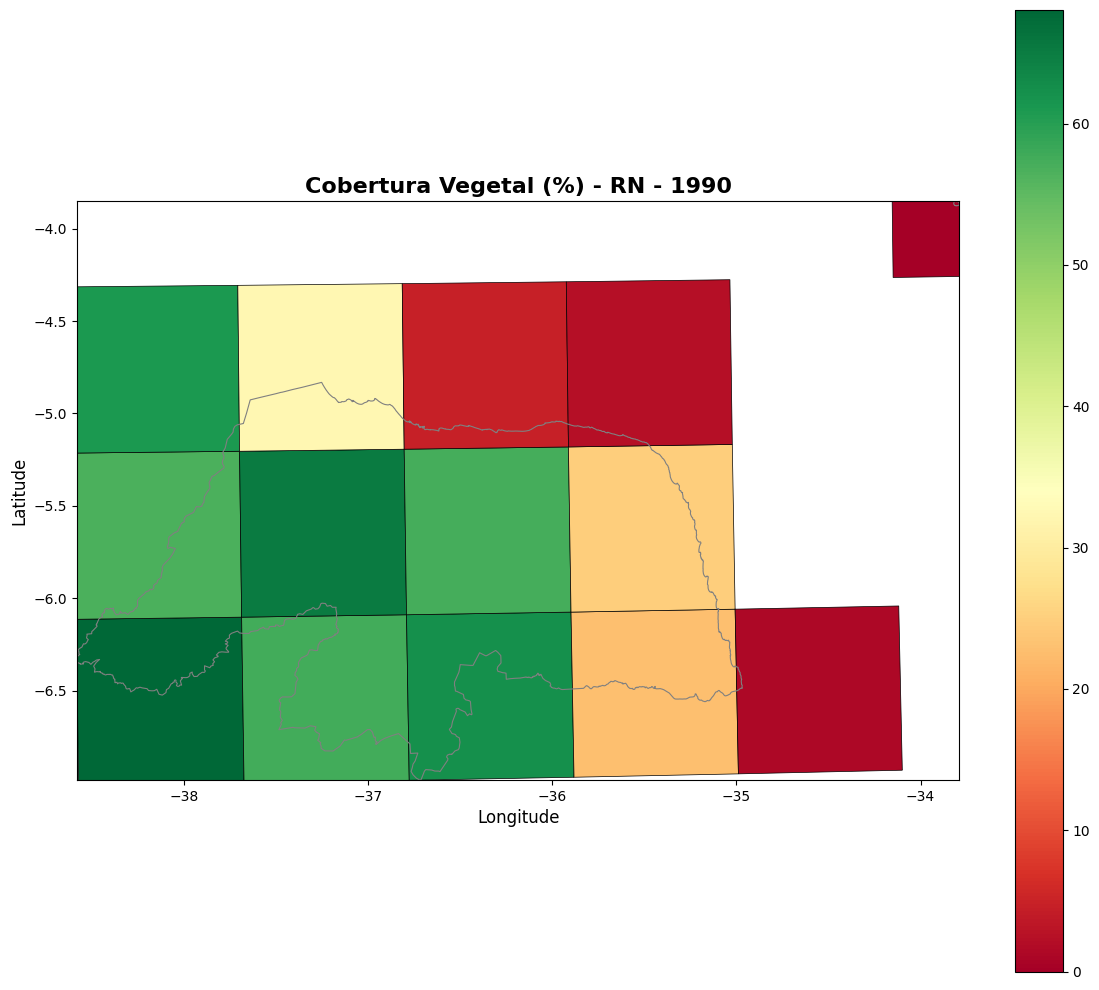

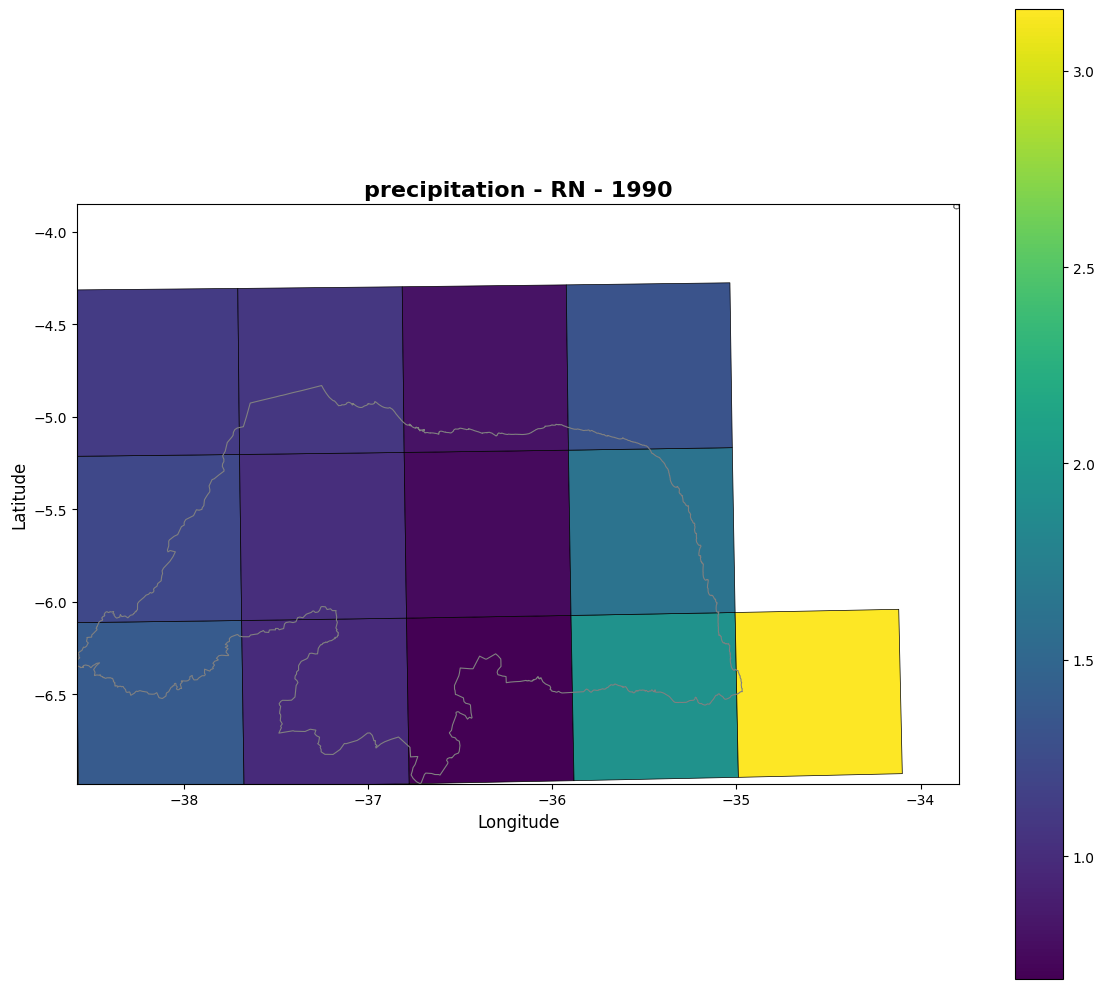

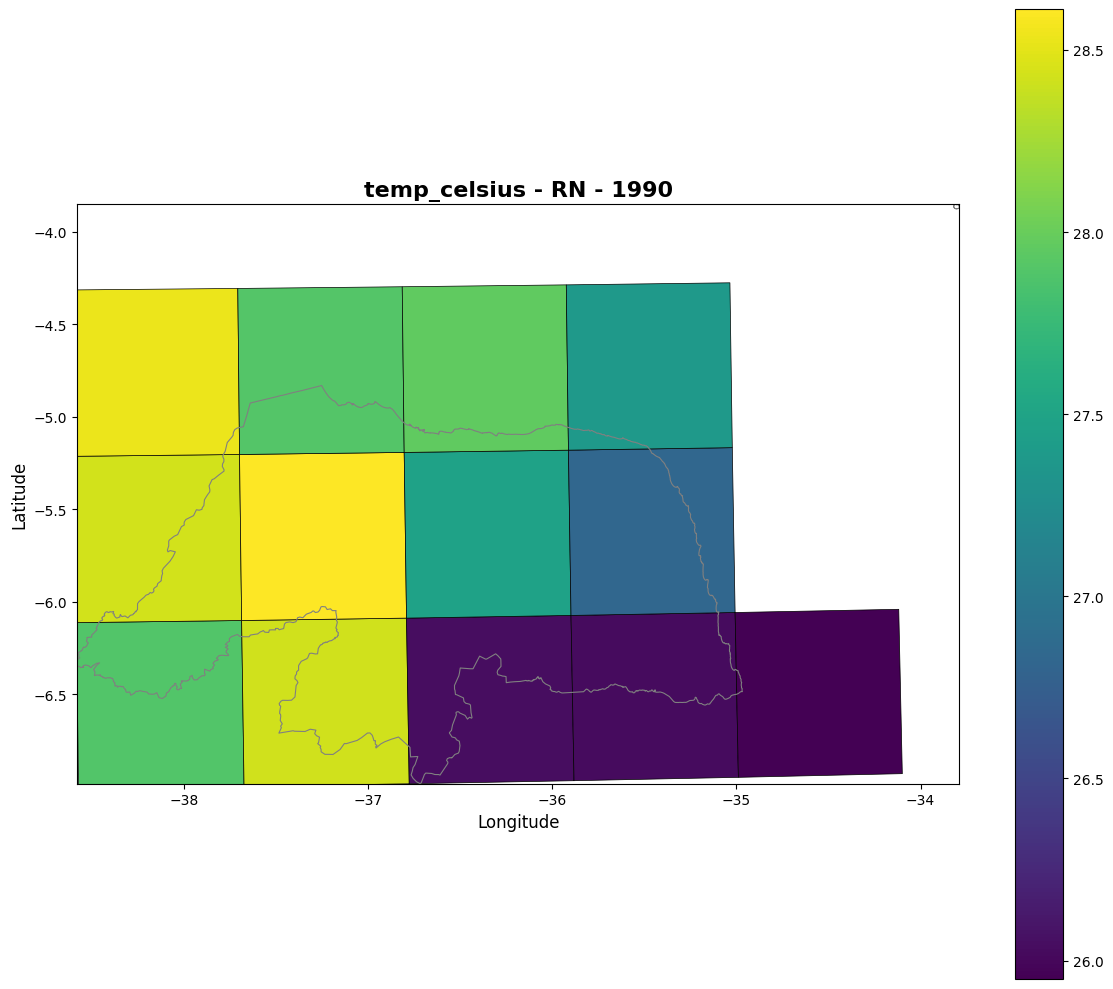

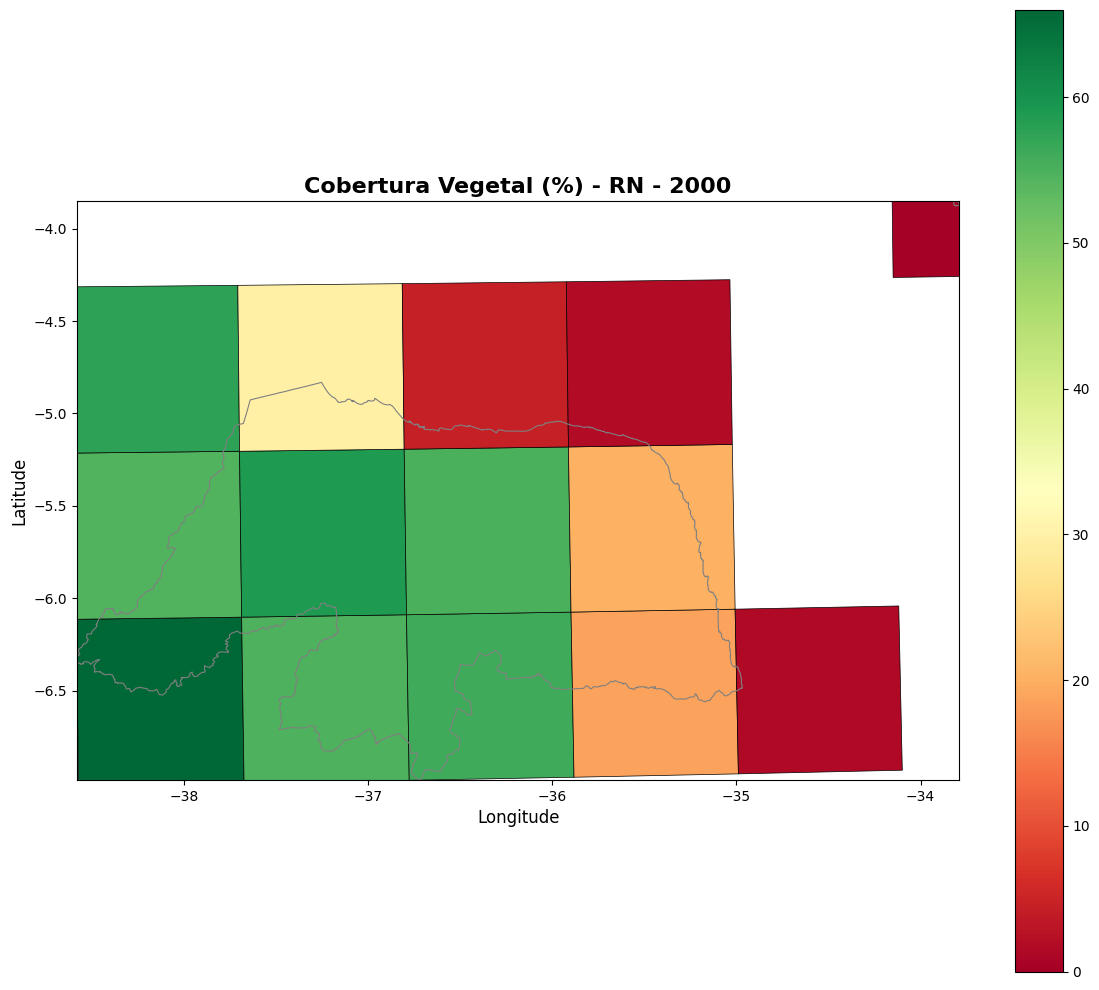

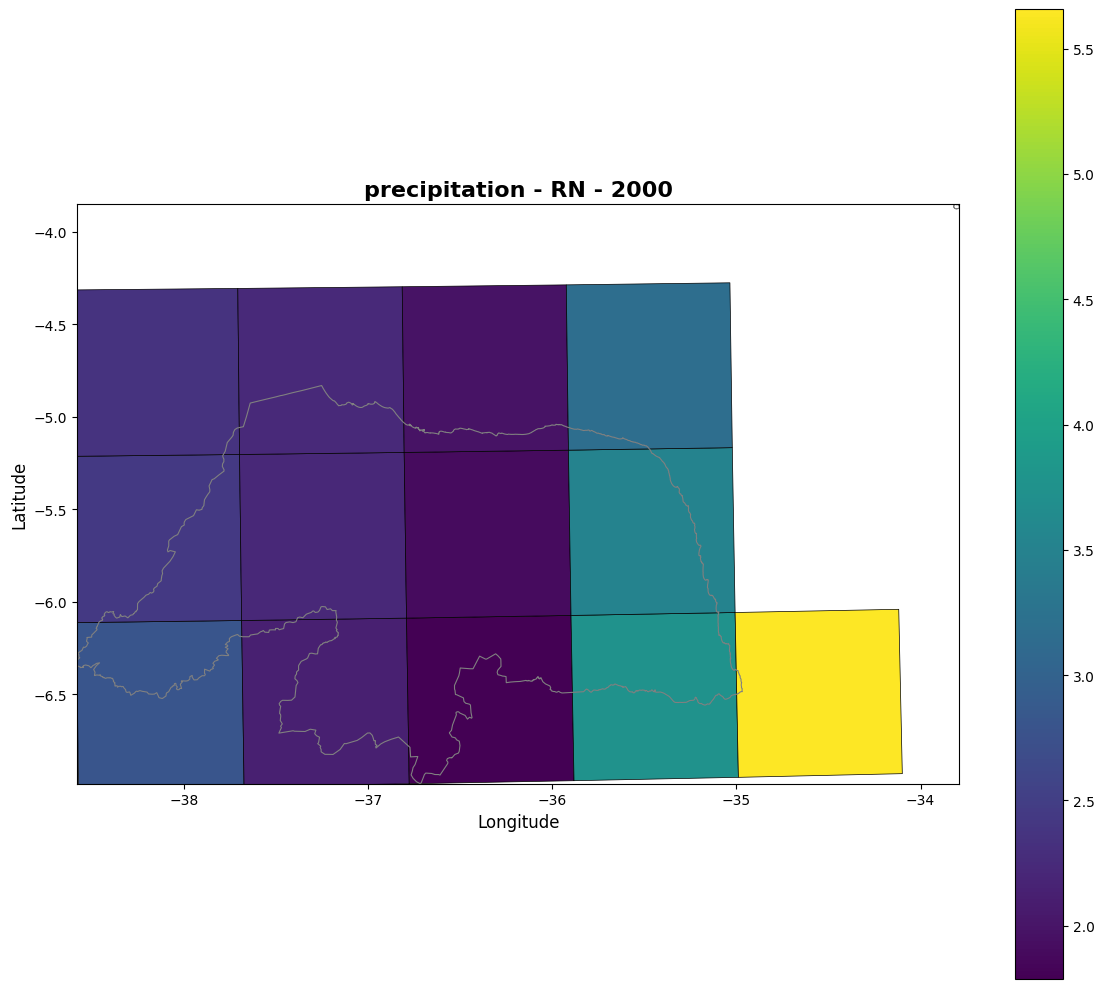

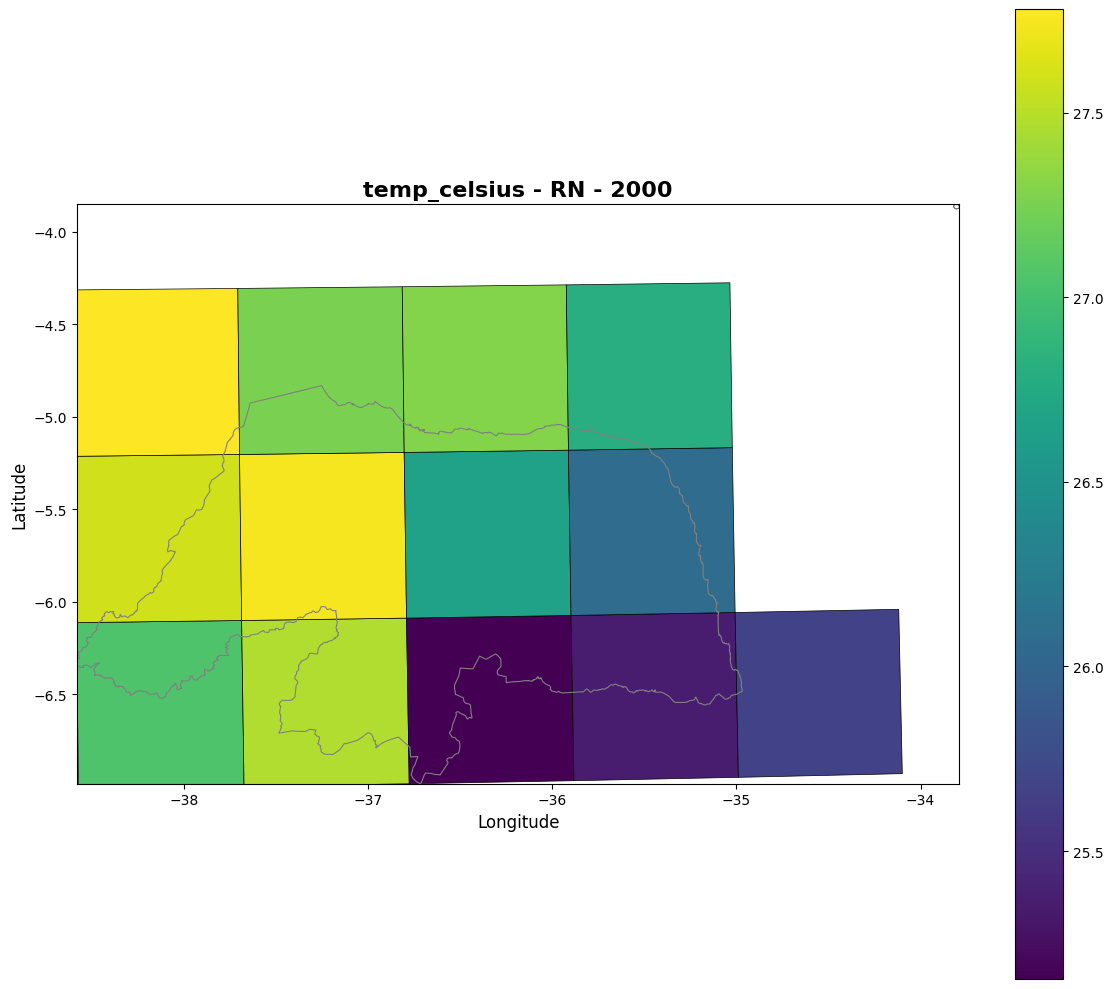

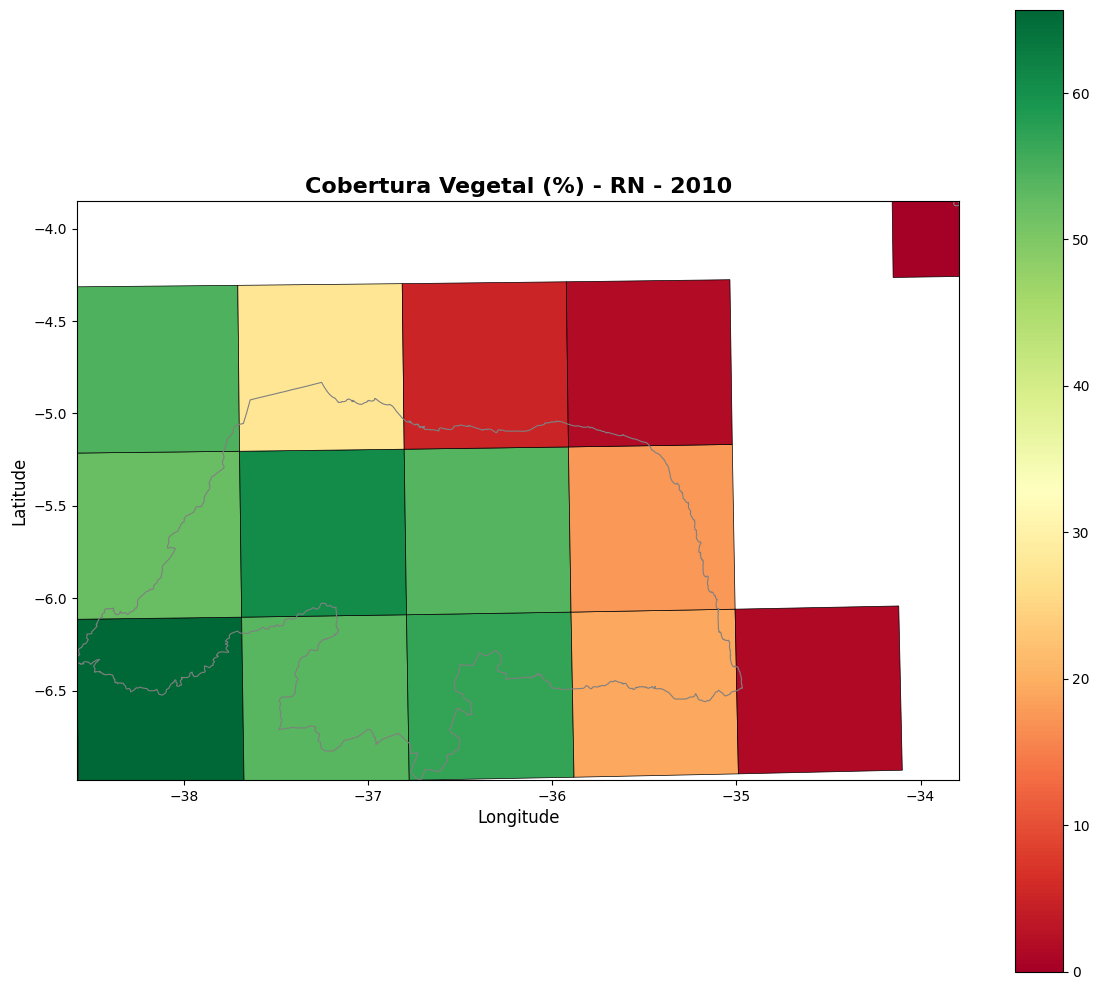

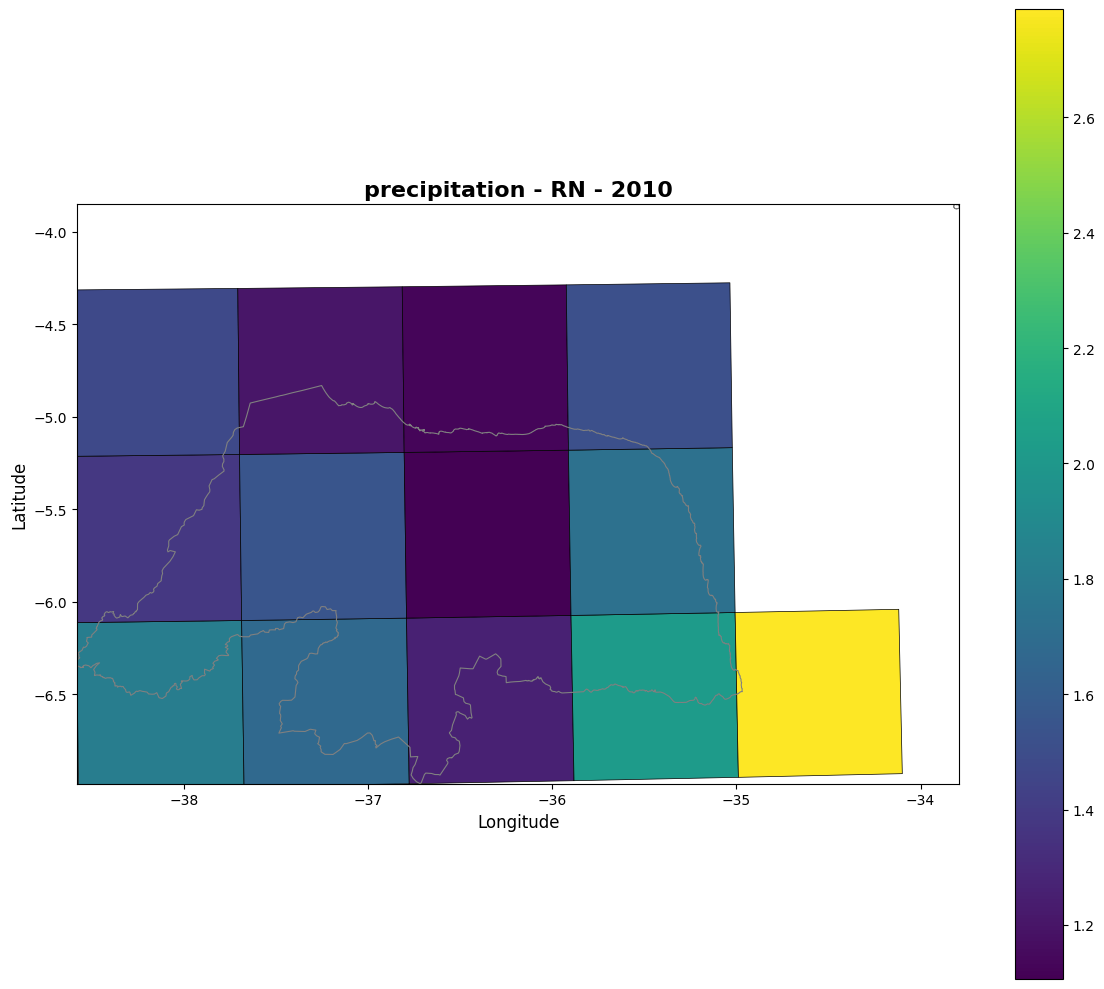

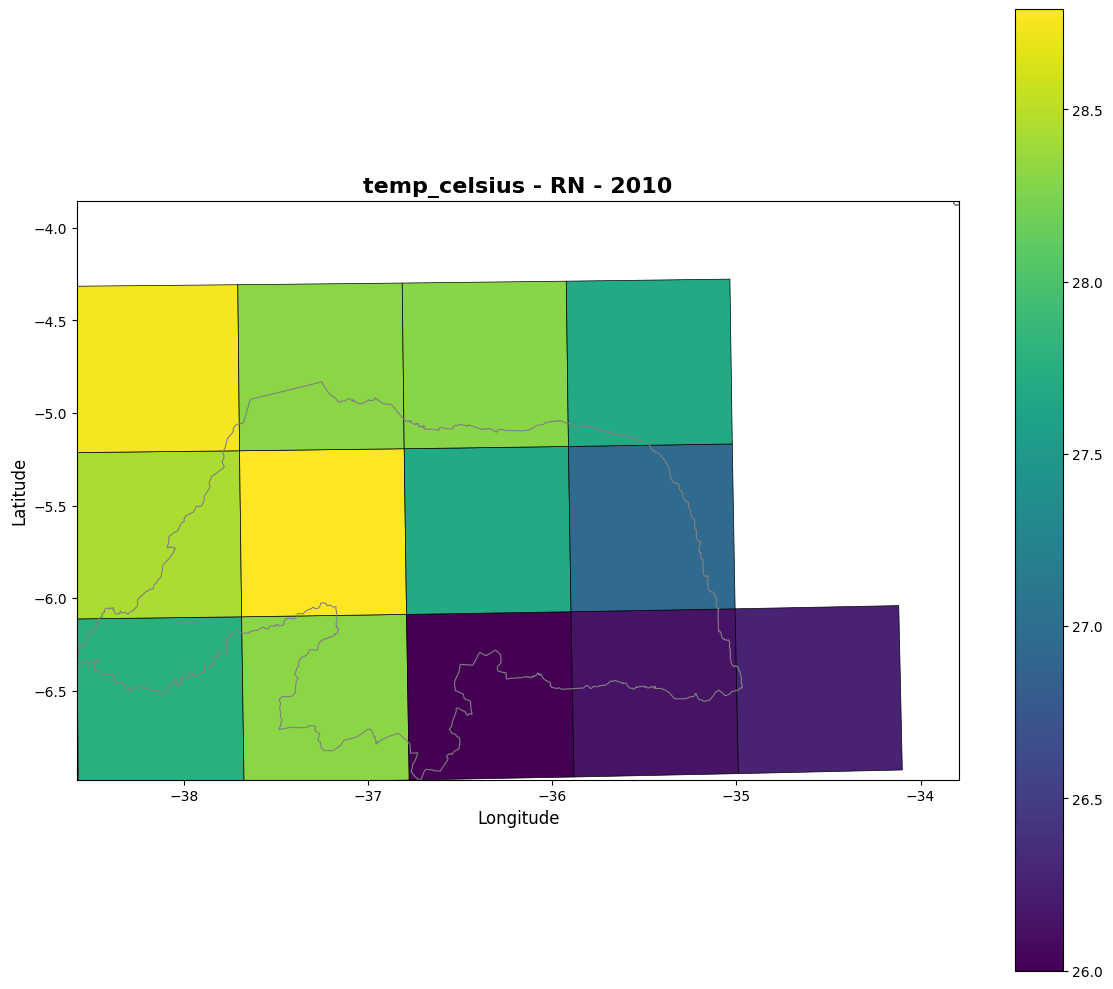

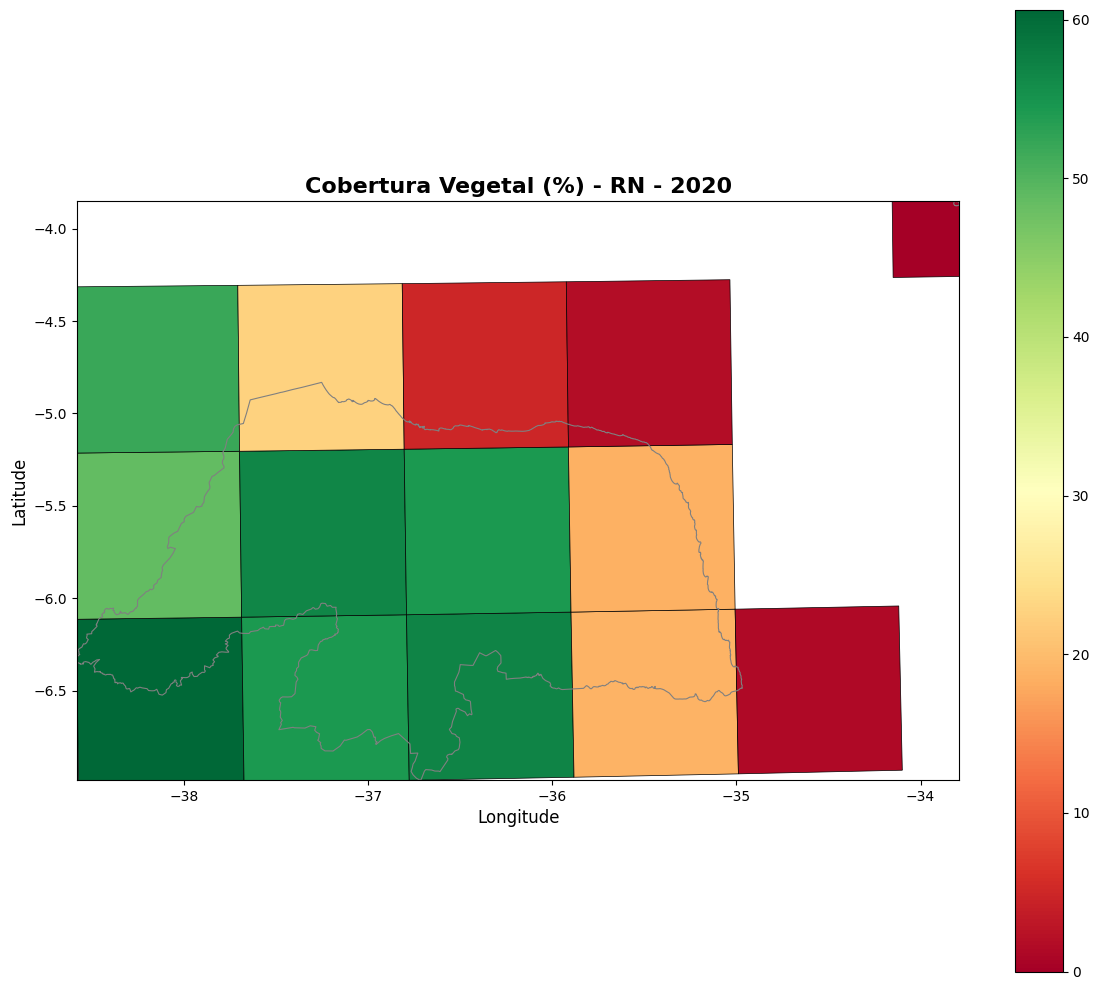

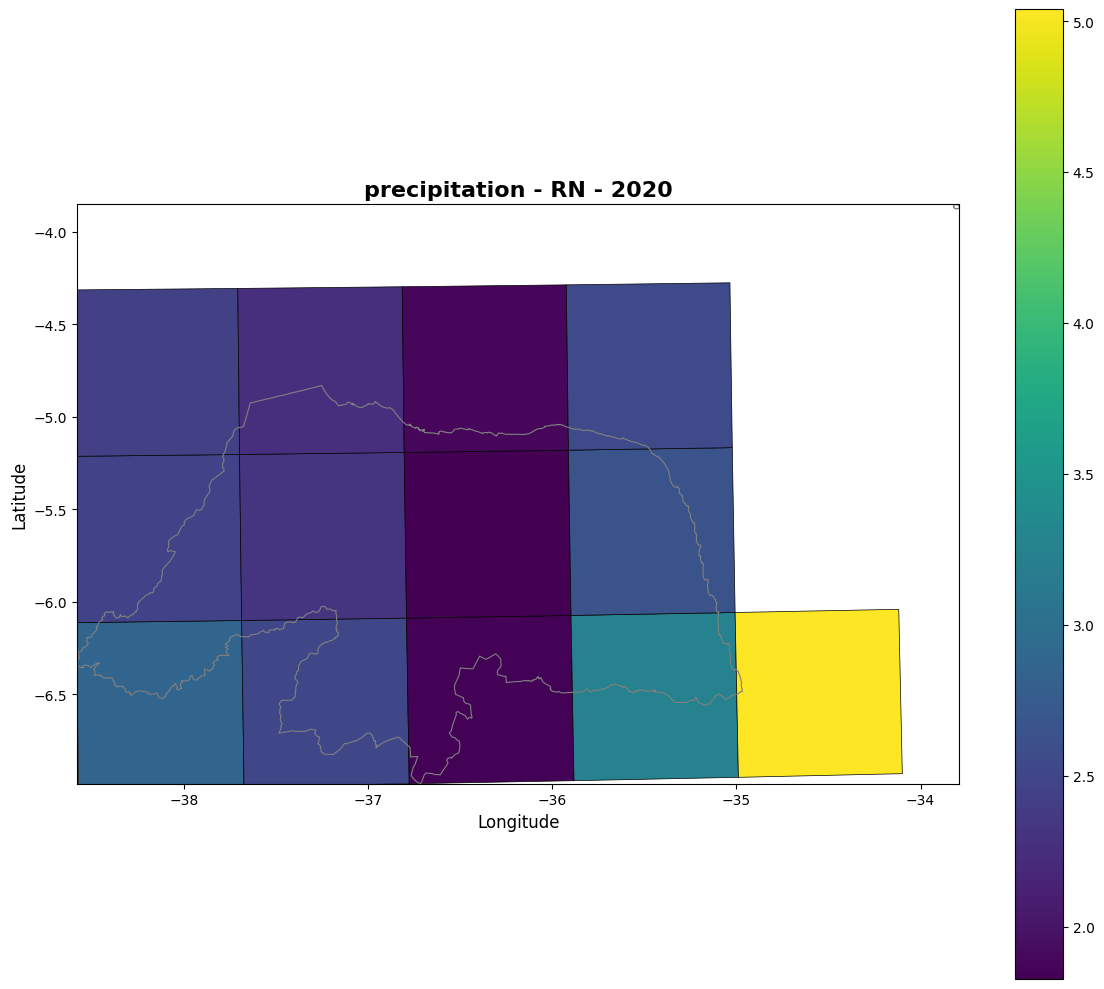

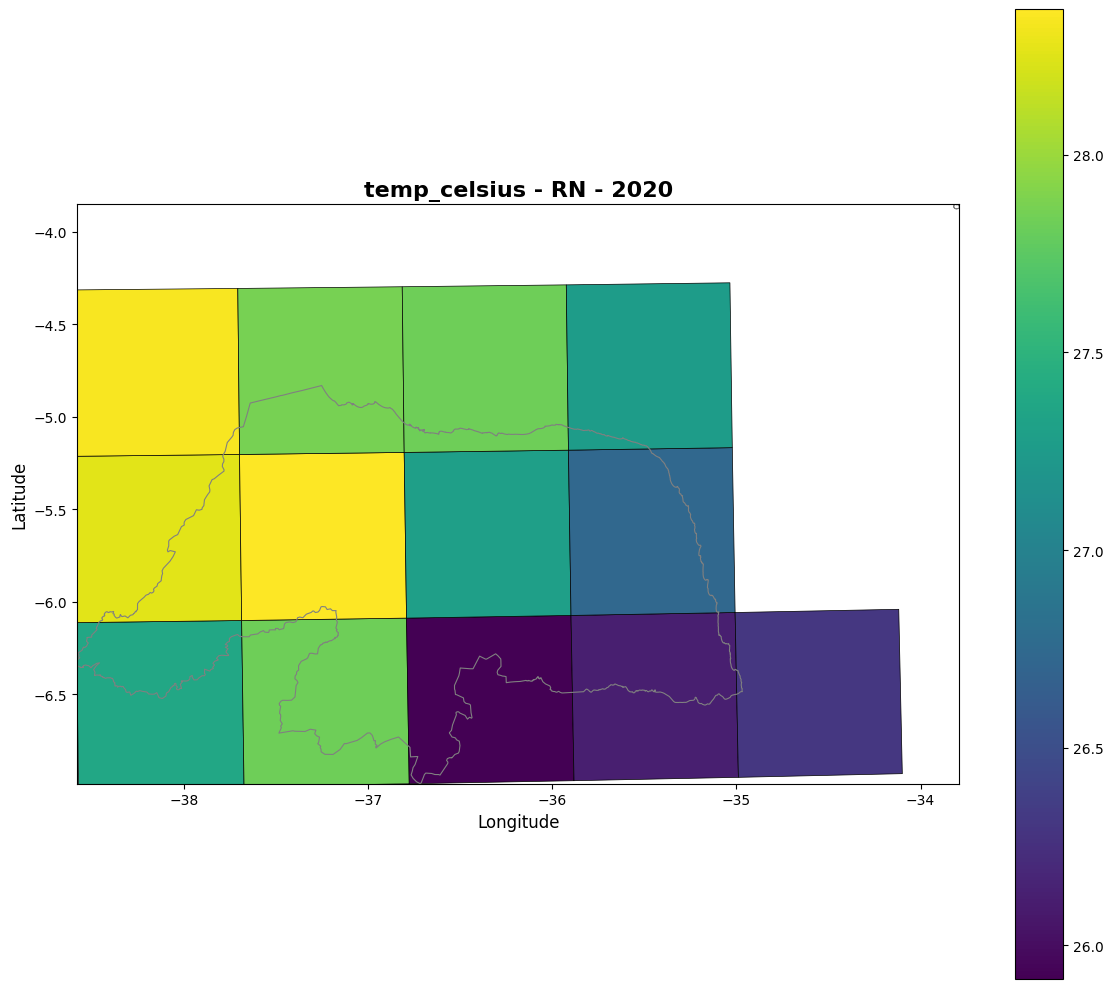

In [25]:
def plotar_por_ano(df_cobertura, df_meteo_list, grade, anos, output_dir='./resultados_por_ano'):
    import os
    os.makedirs(output_dir, exist_ok=True)
    shapefile_brasil = r"F:\Mestrado\Dados_INMET\shapefiles\lml_unidade_federacao_a.shp"
    gdf_brasil = gpd.read_file(shapefile_brasil).to_crs("EPSG:4326")
    gdf_estado = gdf_brasil[gdf_brasil['sigla'] == 'RN'].to_crs("EPSG:4326")
    bounds = gdf_estado.total_bounds
    for ano in anos:
        df_cob_ano = df_cobertura[df_cobertura['ano'] == ano]
        fig, ax = plt.subplots(figsize=(12, 10))
        gdf_estado.boundary.plot(ax=ax, color='gray', linewidth=0.8)
        gdf_estado.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
        grade_plot = grade.to_crs("EPSG:4326").merge(df_cob_ano[['cell_id','pct_vegetacao']], on='cell_id')
        grade_plot.plot(column='pct_vegetacao', cmap='RdYlGn', legend=True,
                        ax=ax, edgecolor='black', linewidth=0.5)
        ax.set_xlim(bounds[0], bounds[2])
        ax.set_ylim(bounds[1], bounds[3])
        ax.set_title(f'Cobertura Vegetal (%) - RN - {ano}', fontsize=16, fontweight='bold')
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/mapa_cobertura_{ano}.png', dpi=300, bbox_inches='tight')
        plt.show()
        for df_meteo, var_name in df_meteo_list:
            df_met_ano = df_meteo[df_meteo['ano'] == ano]
            fig, ax = plt.subplots(figsize=(12, 10))
            gdf_estado.boundary.plot(ax=ax, color='gray', linewidth=0.8)
            gdf_estado.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
            grade_met = grade.to_crs("EPSG:4326").merge(df_met_ano[['cell_id', f'{var_name}_mean']], on='cell_id')
            grade_met.plot(column=f'{var_name}_mean', cmap='viridis', legend=True,
                           ax=ax, edgecolor='black', linewidth=0.5)
            ax.set_xlim(bounds[0], bounds[2])
            ax.set_ylim(bounds[1], bounds[3])
            ax.set_title(f'{var_name} - RN - {ano}', fontsize=16, fontweight='bold')
            ax.set_xlabel('Longitude', fontsize=12)
            ax.set_ylabel('Latitude', fontsize=12)
            plt.tight_layout()
            plt.savefig(f'{output_dir}/mapa_{var_name}_{ano}.png', dpi=300, bbox_inches='tight')
            plt.show()

if __name__ == "__main__":
    CLASSES_VEGETACAO = [1, 3, 4, 5, 6, 9, 10, 11, 49, 50]
    shapefile_brasil = r"F:\Mestrado\Dados_INMET\shapefiles\lml_unidade_federacao_a.shp"
    gdf_brasil = gpd.read_file(shapefile_brasil)
    gdf_rn = gdf_brasil[gdf_brasil['sigla'] == 'RN'].copy()
    grade = criar_grade_analise(gdf_rn, tamanho_celula_km=100)
    grade.to_file("grade_analise_RN.shp")
    rasters_mapbiomas = {
        1990: r"F:\mapbiomas\RN_1990_lclu_recortado.tif",
        2000: r"F:\mapbiomas\RN_2000_lclu_recortado.tif",
        2010: r"F:\mapbiomas\RN_2010_lclu_recortado.tif",
        2020: r"F:\mapbiomas\RN_2020_lclu_recortado.tif"
    }
    df_cobertura = calcular_mudancas_cobertura_vegetal(rasters_mapbiomas, grade, CLASSES_VEGETACAO)
    df_cobertura.to_csv("dados_cobertura_vegetal.csv", index=False)
    df_chirps = pd.read_parquet(r"F:\rn\CHIRPS_RN_diaria_por_pixel_1990_2024.parquet")
    df_meteo_precip = calcular_mudancas_meteorologicas(df_chirps, grade, variavel='precipitation')
    df_meteo_precip.to_parquet("dados_meteorologicos_precipitacao.parquet", index=False)
    df_era5_temp = pd.read_parquet(r"F:\rn\ERA5_TemperaturaMedia_RN_1990_2024.parquet")
    df_meteo_temp = calcular_mudancas_meteorologicas(df_era5_temp, grade, variavel='temp_celsius')
    df_meteo_temp.to_parquet("dados_meteorologicos_temperatura.parquet", index=False)
    df_meteo_list = [(df_meteo_precip, 'precipitation'), (df_meteo_temp, 'temp_celsius')]
    anos = [1990, 2000, 2010, 2020]
    plotar_por_ano(df_cobertura, df_meteo_list, grade, anos, output_dir='./resultados_por_ano')
